# Scheduling benchmarks analysis

## Library

In [3]:
import matplotlib.pyplot as plt
from typing import Optional, List
import pandas as pd
import os
import re
import json
import subprocess

#### Global variables

In [4]:
TRACE_CMD_CACHE_FILENAME = "trace_cmd_runtimes"
RESULTS_DIR_PATH = "../results"

def get_result_dir_path(result_dir_name):
    return os.path.join(RESULTS_DIR_PATH, result_dir_name)

#### Trace-cmd results processing functions

In [5]:
def get_run_index(filename) -> int :
    match = re.search(r'_(\d+)\.dat', filename)
    if match:
        return int(match.group(1))
    return None


def get_trace_duration(dat_file_path: str) :
    result = subprocess.run(
        ["trace-cmd", "report", "--first-event", "--last-event", dat_file_path],
        stdout = subprocess.PIPE,
        universal_newlines = True
    )

    firsts = []
    lasts = []
    for line in result.stdout.split("\n"):
        match = re.search(r'\s+\d+\tFirst event:\s*(\d+\.\d+)\tLast event:\s*(\d+\.\d+)', line)
        if match:
            firsts.append(float(match.group(1)))
            lasts.append(float(match.group(2)))
    return max(lasts) - min(firsts)
    

def get_runtimes_dataframe(dir_path, use_cache = True, sort_by_duration = True) :
    if not os.path.exists(dir_path) :
        return None

    cache_path = os.path.join(dir_path, TRACE_CMD_CACHE_FILENAME + ".csv")
    if use_cache and os.path.isfile(cache_path):
        df = pd.read_csv(cache_path)
    else :
        dat_files = [file for file in os.listdir(dir_path) if file.endswith('.dat')]
        ndat = len(dat_files)
        if ndat == 0 :
            print(f"get_runtimes_dataframe : no trace files found in {dir_path}, skipping")
            return None
        
        df = pd.DataFrame({'filename': dat_files})
        df['duration'] = df['filename'].map(lambda x: get_trace_duration(os.path.join(dir_path, x)))
        df.sort_values('duration', ignore_index=True, inplace=True)
        df.to_csv(cache_path, encoding='utf-8', index=False)

    if sort_by_duration :
        df.sort_values('duration', ignore_index=True, inplace=True)

    df['run_index'] = df['filename'].map(get_run_index)
    min_duration = df['duration'].min()
    df['variation'] = (df['duration'] - min_duration) * 100 / min_duration
    return df

#### Visualization params

In [6]:
nb_enabled_color = "tab:orange"
nb_disabled_color = "tab:blue"

figure_height = 8 # TODO Group config variables
min_figure_width = 40

line_width = 3.0

#### Visualization functions

In [7]:
# Naming convention :
# - run : 1 set of files, either nb or no_nb
# - benchmark / result : 1 series of nb and 1 series of no_nb



def init_runtimes_plot():
    # plt.figure(figsize=(fig_width, 5))
    # plt.legend(loc="upper left")
    plt.xlabel("Nth run")
    plt.ylabel("Run time (seconds)")
    plt.grid(axis="y", which="both")
    plt.grid(axis="x", which="major")
    
    # ax = plt.gca()
    # ax.ticklabel_format(axis="x", useOffset=1.0)
    

def plot_hyperfine_run(times: List[float], label = None, color = None, init_plot = True):
    if init_plot:
        init_runtimes_plot()
        
    plt.plot(range(len(times)), times, label = label, color = color, linewidth=line_width)
    
    current_xticks_count = len(plt.xticks()[0])
    if len(times) > current_xticks_count :
        plt.xticks(range(len(times)), rotation=45)
        plt.xlim(-1, len(times))
        
    candidate_ylim_max = max(times) * 1.2
    if candidate_ylim_max > plt.ylim()[1] :
        plt.ylim(0, candidate_ylim_max)
        
    fig = plt.gcf()
    candidate_width = max(int(len(times) / 4), min_figure_width)
    curr_width = fig.get_size_inches()[0]
    if candidate_width > curr_width :
        fig.set_size_inches(candidate_width, figure_height)
    
    if label :
        plt.legend(loc="upper left")
    
    
def plot_hyperfine_benchmark(times_nb: List[float], times_no_nb: List[float], benchmark_name: str, sort_values = True) :
    if sort_values:
        times_nb.sort()
        times_no_nb.sort()
        
    init_runtimes_plot()
    if times_nb :
        plot_hyperfine_run(times_nb, benchmark_name + " | NB enabled", nb_enabled_color, False)
    if times_no_nb :
        plot_hyperfine_run(times_no_nb, benchmark_name + " | NB disabled", nb_disabled_color, False)
    plot_title = benchmark_name + " sorted" if sort_values else " unsorted"
    plt.title(plot_title)
    # plt.legend()
    plt.show()
    
    
    
    
def plot_trace_cmd_run(df, label = None, color = None, init_plot = True, show_run_index = True) :
    if init_plot:
        init_runtimes_plot()
    plt.plot(df.index, df['duration'], label=label, color=color, linewidth=line_width)
    
    current_xticks_count = len(plt.xticks()[0])
    if len(df) > current_xticks_count :
        plt.xticks(range(len(df)), rotation=45)
        plt.xlim(-1, len(df))
        
    candidate_ylim_max = df['duration'].max() * 1.2
    if candidate_ylim_max > plt.ylim()[1] :
        plt.ylim(0, candidate_ylim_max)
        
    fig = plt.gcf()
    candidate_width = max(int(len(df) / 4), min_figure_width)
    curr_width = fig.get_size_inches()[0]
    if candidate_width > curr_width :
        fig.set_size_inches(candidate_width, figure_height)
    
    if label :
        plt.legend(loc="upper left")

    if show_run_index :
        ax = plt.gca()
        for idx in df.index:
            ax.text(idx, df['duration'][idx], df['run_index'][idx], fontsize=8)
    

def plot_trace_cmd_runtimes(df_nb, df_no_nb, benchmark_name, show_run_index = True, fig_width = 12) :
    if df_nb is None and df_no_nb is None :
        print("plot_trace_cmd_runtimes : ERROR - both with and without NUMA balancing data frames are None")
        return
        
    plt.figure(figsize=(fig_width, figure_height))

    df_nb_index_len = 0
    df_no_nb_index_len = 0
    max_val = 0
    if df_nb is not None :
        plt.plot(df_nb.index, df_nb['duration'], label = "With NUMA balancing - Run index", color="tab:orange")
        df_nb_index_len = len(df_nb.index)
        max_val = max(df_nb['duration'])
    if df_no_nb is not None :
        plt.plot(df_no_nb.index, df_no_nb['duration'], label = "Without NUMA balancing - Run index", color="tab:blue")
        max_val = max(max_val, max(df_no_nb['duration']))
    plt.xticks(range(max(df_nb_index_len, df_no_nb_index_len)))

    
    plt.legend(loc="upper left")
    plt.ylabel("Run time (seconds)")

    xlabel_str = "Nth slowest run"
    if show_run_index :
        xlabel_str += ". The actual run index is on the lines"
    plt.xlabel(xlabel_str)
    plt.title(benchmark_name)
    plt.grid(axis="y", which="both")
    plt.grid(axis="x", which="major")
    
    ax = plt.gca()
    ax.set_ylim(0, max_val * 1.2)
    ax.ticklabel_format(axis="x", useOffset=1.0)
    plt.xticks(rotation=45)

    if show_run_index :
        if df_nb is not None :
            for idx in df_nb.index:
                ax.text(idx, df_nb['duration'][idx], get_run_index(df_nb['filename'][idx]), fontsize=8)
        if df_no_nb is not None :
            for idx in df_no_nb.index:
                ax.text(idx, df_no_nb['duration'][idx], get_run_index(df_no_nb['filename'][idx]), fontsize=8)

    # plt.minorticks_on()
    plt.show()

#### Summary functions

In [8]:
def plot_trace_cmd_benchmark_dir2(benchmark_dir_name, show_run_index = True, sort_by = None, fig_width = 28) :
    df_nb = get_runtimes_dataframe(os.path.join(benchmark_dir_name, "nb"))
    df_no_nb = get_runtimes_dataframe(os.path.join(benchmark_dir_name, "no_nb"))

    if sort_by is not None :
        if df_nb is not None :
            df_nb.sort_values(sort_by, ignore_index=True, inplace=True)
        if df_no_nb is not None :
            df_no_nb.sort_values(sort_by, ignore_index=True, inplace=True)
    
    plot_trace_cmd_runtimes(df_nb, df_no_nb, benchmark_dir_name, show_run_index, fig_width)

def plot_trace_cmd_benchmark_dir_old(benchmark_dir_name, show_run_index = True, sort_by = None) :
    if not sort_by :
        sort_by = 'duration'
    
    dir_path = get_result_dir_path(benchmark_dir_name)
    nb_dir_path = os.path.join(dir_path, "nb")
    no_nb_dir_path = os.path.join(dir_path, "no_nb")

    df_nb = get_runtimes_dataframe(nb_dir_path) if os.path.exists(nb_dir_path) else None
    df_no_nb = get_runtimes_dataframe(no_nb_dir_path) if os.path.exists(no_nb_dir_path) else None

    init_runtimes_plot()
    if df_nb is not None :
        df_nb.sort_values(sort_by, ignore_index=True, inplace=True)
        plot_trace_cmd_run(df_nb, "With NUMA balancing", nb_enabled_color, False, show_run_index)
    if df_no_nb is not None :
        df_no_nb.sort_values(sort_by, ignore_index=True, inplace=True)
        plot_trace_cmd_run(df_no_nb, "Without NUMA balancing", nb_disabled_color, False, show_run_index)
    plot_title = benchmark_dir_name + " sorted by " + sort_by
    plt.title(plot_title)
    plt.show()
    
    
trace_cmd_folders_color = {
    "nb": "tab:orange",
    "nb_memory": "tab:purple",
    "nb_tasks": "tab:green",
    "no_nb": "tab:blue"
}
    
def plot_trace_cmd_benchmark_dir(benchmark_dir_name, show_run_index = True, sort_by = None, ) :
    if not sort_by :
        sort_by = 'duration'
        
    benchmark_dir_path = get_result_dir_path(benchmark_dir_name)
    contents = os.listdir(benchmark_dir_path)
    init_runtimes_plot()
    for c in contents :
        dir_path = os.path.join(benchmark_dir_path, c)
        if not os.path.isdir(dir_path) :
            continue
        
        df = get_runtimes_dataframe(dir_path)
        if df is None :
            continue
        df.sort_values(sort_by, ignore_index=True, inplace=True)
        color = trace_cmd_folders_color[c] if c in trace_cmd_folders_color else "tab:gray"
        plot_trace_cmd_run(df, c, color, False, show_run_index)
        
    plot_title = benchmark_dir_name + " sorted by " + sort_by
    plt.title(plot_title)
    plt.show()


def plot_trace_cmd_benchmark_dir_plus(benchmark_dir_name, label_prefix, show_run_index = True, sort_by = None) :
    if not sort_by :
        sort_by = 'duration'
        
    benchmark_dir_path = get_result_dir_path(benchmark_dir_name)
    contents = os.listdir(benchmark_dir_path)
    # init_runtimes_plot()
    for c in contents :
        dir_path = os.path.join(benchmark_dir_path, c)
        if not os.path.isdir(dir_path) :
            continue
        
        df = get_runtimes_dataframe(dir_path)
        if df is None :
            continue
        df.sort_values(sort_by, ignore_index=True, inplace=True)
        # color = trace_cmd_folders_color[c] if c in trace_cmd_folders_color else "tab:gray"
        plot_trace_cmd_run(df,  label_prefix + " " + c, None, False, show_run_index)


## Experiments

#### Available results
Trace cmd results - `.dat` files - are expected to be located in the `./results` directory. \

In [9]:
def get_benchmarks_dirs() :
    return sorted([dir for dir in os.listdir(RESULTS_DIR_PATH) if os.path.isdir(get_result_dir_path(dir))])

def get_hyperfine_runtimes(run_dir_path) -> List[float]:
    hyperfine_run_files = [file for file in os.listdir(run_dir_path) if file.endswith(".json")]
    if len(hyperfine_run_files) == 0 :
        return []
    if len(hyperfine_run_files) > 1 :
        print("WARNING : More than 1 hyperfine run files found in", run_dir_path)
    
    with open(os.path.join(run_dir_path, hyperfine_run_files[0])) as f:
        data = json.load(f)
    return data['results'][0]['times']

In [10]:
def get_hyperfine_runtimes(run_dir_path) -> List[float]:
    hyperfine_run_files = [file for file in os.listdir(run_dir_path) if file.endswith(".json")]
    if len(hyperfine_run_files) == 0 :
        return []
    if len(hyperfine_run_files) > 1 :
        print("WARNING : More than 1 hyperfine run files found in", run_dir_path)
    
    with open(os.path.join(run_dir_path, hyperfine_run_files[0])) as f:
        data = json.load(f)
    return data['results'][0]['times']


def plot_hyperfine_benchmark_dir(benchmark_dir_name, sort_values = True):
    dir_path = get_result_dir_path(benchmark_dir_name)
    nb_dir_path = os.path.join(dir_path, "nb")
    no_nb_dir_path = os.path.join(dir_path, "no_nb")

    times_nb = get_hyperfine_runtimes(nb_dir_path) if os.path.exists(nb_dir_path) else None
    times_no_nb = get_hyperfine_runtimes(no_nb_dir_path) if os.path.exists(no_nb_dir_path) else None
    
    if sort_values:
        times_nb.sort()
        times_no_nb.sort()
    init_runtimes_plot()
    if times_nb :
        plot_hyperfine_run(times_nb, "With NUMA balancing", nb_enabled_color, False)
    if times_no_nb :
        plot_hyperfine_run(times_no_nb, "Without NUMA balancing", nb_disabled_color, False)
    plot_title = benchmark_dir_name + " sorted" if sort_values else " unsorted"
    plt.title(plot_title)
    plt.show()

#### Hyperfine benchmarks

In [11]:
print("Hyperfine benchmarks")
for dir_name in get_benchmarks_dirs() :
    dir_path = get_result_dir_path(dir_name)
    nb_dir_path = os.path.join(dir_path, "nb")
    no_nb_dir_path = os.path.join(dir_path, "no_nb")
    
    nb_run_count = len(get_hyperfine_runtimes(nb_dir_path)) if os.path.exists(nb_dir_path) else 0
    no_nb_run_count = len(get_hyperfine_runtimes(no_nb_dir_path)) if os.path.exists(no_nb_dir_path) else 0
    
    if nb_run_count or no_nb_run_count :
        nb_runs_text = f"{nb_run_count} NB runs"
        no_nb_runs_text = f"{no_nb_run_count} NO NB runs"
        print(f" - {dir_name.ljust(28, ' ')} {nb_runs_text.ljust(16, ' ')} {no_nb_runs_text}")

Hyperfine benchmarks
 - bt.B.servan-1.v6.8-rc3       200 NB runs      200 NO NB runs
 - bt.C.servan-1.v6.8-rc3       200 NB runs      200 NO NB runs
 - cg.B.dahu-18.v6.8-rc3        200 NB runs      200 NO NB runs
 - cg.C.dahu-18.v6.8-rc3        200 NB runs      200 NO NB runs
 - lu.B.servan-1.v6.8-rc3       200 NB runs      200 NO NB runs
 - lu.C.servan-1.v6.8-rc3       200 NB runs      200 NO NB runs


In [12]:
for dir_name in get_benchmarks_dirs() :
    dir_path = get_result_dir_path(dir_name)
    nb_dir_path = os.path.join(dir_path, "nb")
    no_nb_dir_path = os.path.join(dir_path, "no_nb")
    
    times_nb = get_hyperfine_runtimes(nb_dir_path) if os.path.exists(nb_dir_path) else []
    times_no_nb = get_hyperfine_runtimes(no_nb_dir_path) if os.path.exists(no_nb_dir_path) else []
        
    if not times_nb and not times_no_nb :
        continue
    
    # print(dir_name)
    # plot_hyperfine_benchmark(times_nb, times_no_nb, dir_name, sort_values=True)
    

#### Trace-cmd benchmarks

In [13]:
def count_trace_files(directory) :
    return len([file for file in os.listdir(directory) if file.endswith('.dat')])

trace_cmd_benchmark_dirs = []

for dir_name in get_benchmarks_dirs() :
    dir_path = get_result_dir_path(dir_name)
    nb_dir_path = os.path.join(dir_path, "nb")
    no_nb_dir_path = os.path.join(dir_path, "no_nb")
    
    nb_run_count = count_trace_files(nb_dir_path) if os.path.exists(nb_dir_path) else 0
    no_nb_run_count = count_trace_files(no_nb_dir_path) if os.path.exists(no_nb_dir_path) else 0
    
    if nb_run_count or no_nb_run_count :
        trace_cmd_benchmark_dirs.append(dir_name)
        nb_runs_text = f"{nb_run_count} NB runs"
        no_nb_runs_text = f"{no_nb_run_count} NO NB runs"
        print(f" - {dir_name.ljust(28, ' ')} {nb_runs_text.ljust(16, ' ')} {no_nb_runs_text}")

 - bt.B.29-02.dahu-2.v6.1.0-17  300 NB runs      0 NO NB runs
 - bt.B.dahu-17.v6.8-rc3        200 NB runs      200 NO NB runs
 - bt.C.dahu-28.v6.8-rc3        100 NB runs      100 NO NB runs
 - bt.C.dahu.v6.1.0-17          50 NB runs       0 NO NB runs
 - bt.C.yeti.v6.1.0-17          50 NB runs       10 NO NB runs
 - cg.C.26-02--2.servan-2.v6.8-rc3 100 NB runs      10 NO NB runs
 - cg.C.26-02.servan-2.v6.8-rc3 50 NB runs       50 NO NB runs
 - cg.C.and.bt.B.servan-2.v6.8-rc3 200 NB runs      200 NO NB runs
 - cg.C.servan-1.v6.8-rc3       200 NB runs      200 NO NB runs
 - cg.C.servan-2.thermal2.v6.8-rc3 300 NB runs      0 NO NB runs
 - cg.C.servan-2.v6.1.0-17      100 NB runs      100 NO NB runs
 - cg.C.servan.v6.1.0-17        20 NB runs       10 NO NB runs
 - ep.D.dahu.v6.1.0-17          100 NB runs      100 NO NB runs
 - ft.C.01-03.yeti-2.v6.1.0     200 NB runs      200 NO NB runs
 - ft.C.dahu.v6.1.0-17          100 NB runs      100 NO NB runs
 - ft.C.yeti-1.v6.1.0-17        100 NB ru

#### LU - Yeti

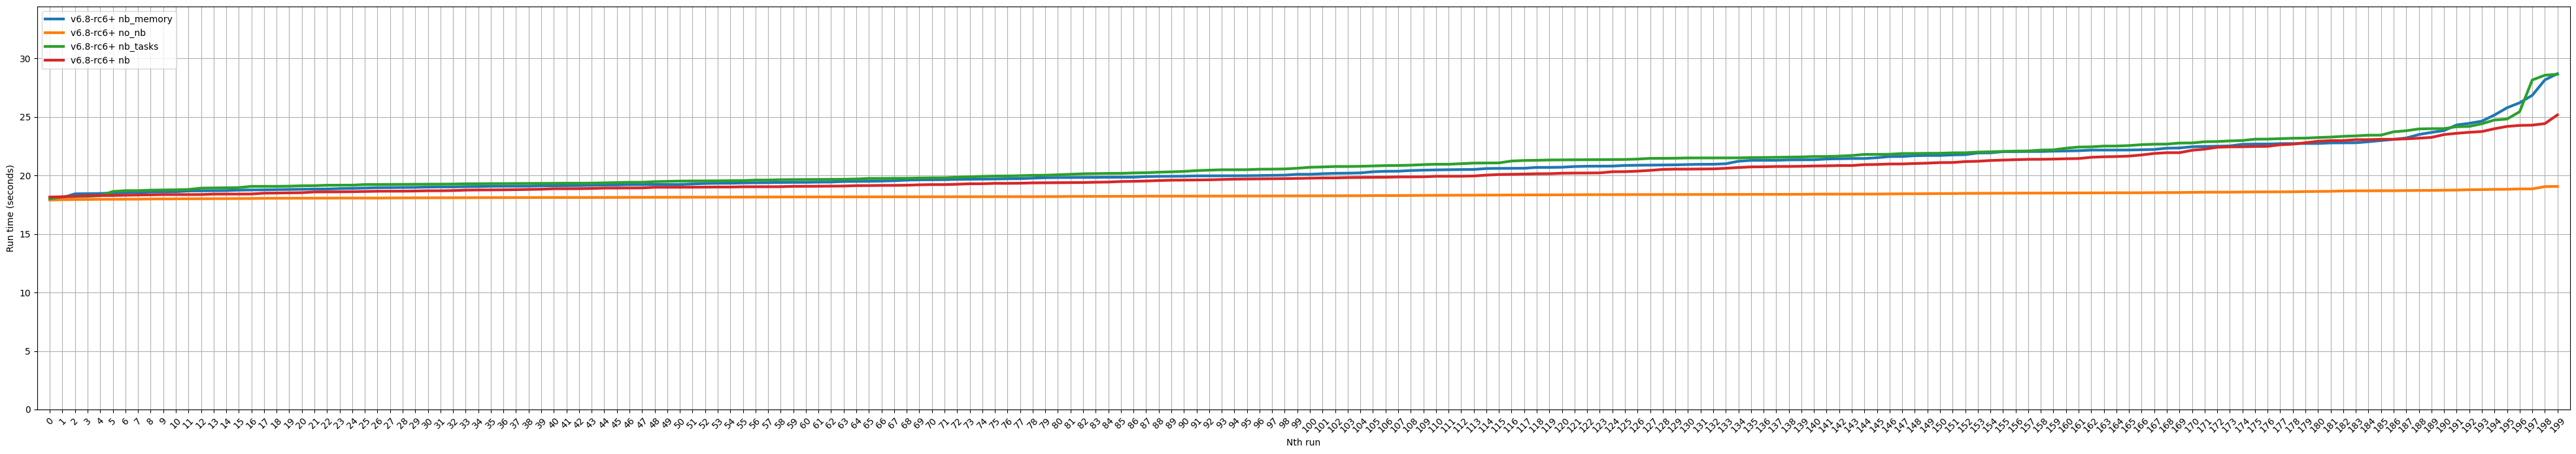

In [21]:
sort_by='duration'
# sort_by='run_index'
init_runtimes_plot()

# plot_trace_cmd_benchmark_dir_plus("lu.C.29-02.yeti-1.v6.8-rc6+", "v6.8-rc6+ toggles", show_run_index=False, sort_by=sort_by)
plot_trace_cmd_benchmark_dir_plus("lu.C.yeti-4.v6.8-rc3", "v6.8-rc3", show_run_index=False, sort_by=sort_by)
plt.show()

#### UA - Yeti

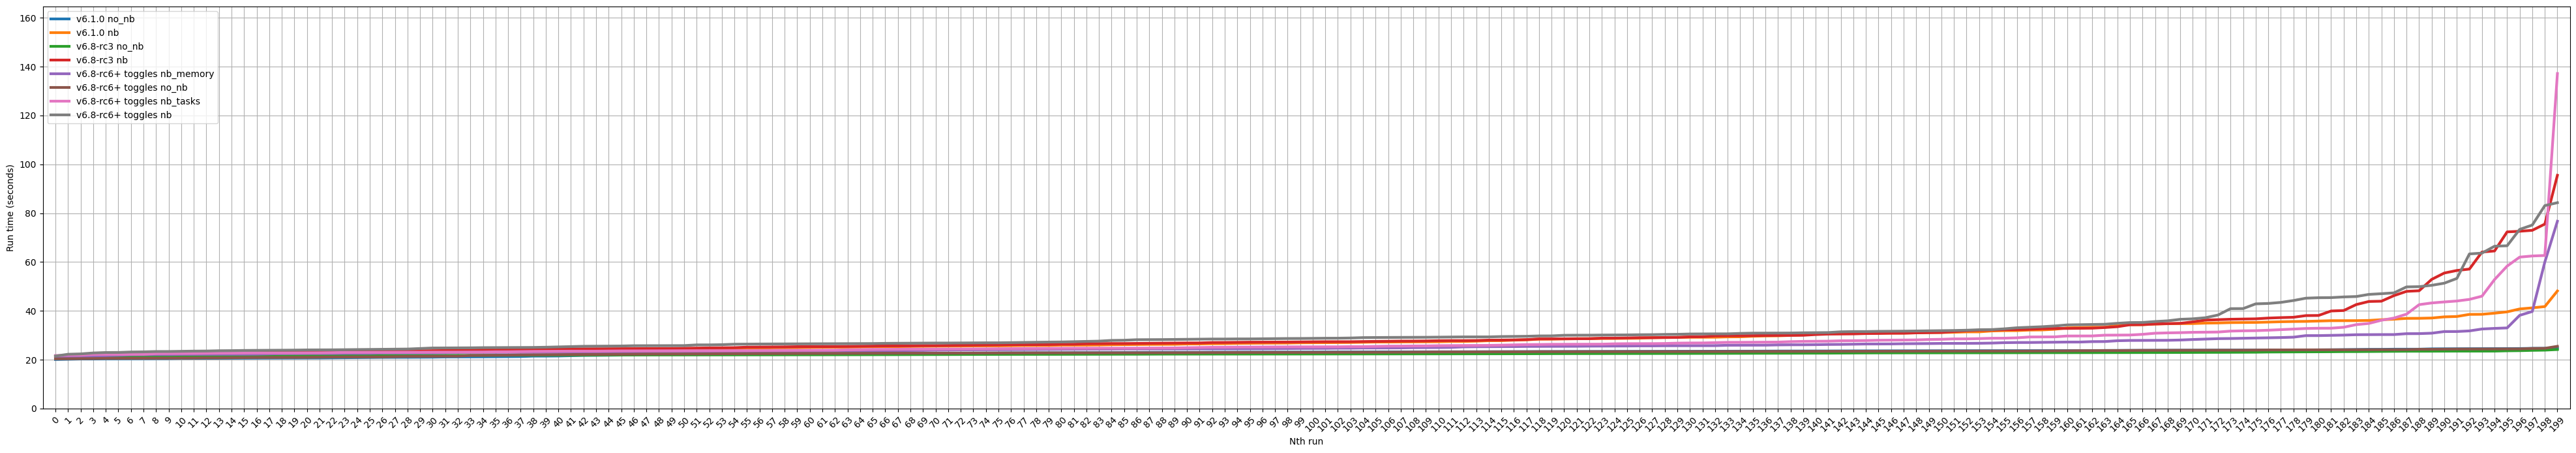

In [25]:
sort_by='duration'
# sort_by='run_index'
init_runtimes_plot()

plot_trace_cmd_benchmark_dir_plus("ua.C.01-03.yeti-2.v6.1.0", "v6.1.0", show_run_index=False, sort_by=sort_by)
plot_trace_cmd_benchmark_dir_plus("ua.C.28-02.yeti-3.v6.8-rc3", "v6.8-rc3", show_run_index=False, sort_by=sort_by)
plot_trace_cmd_benchmark_dir_plus("ua.C.29-02.yeti-2.v6.8-rc6+", "v6.8-rc6+ toggles", show_run_index=False, sort_by=sort_by)
plt.show()

#### Kernel v6.8.0-rc3

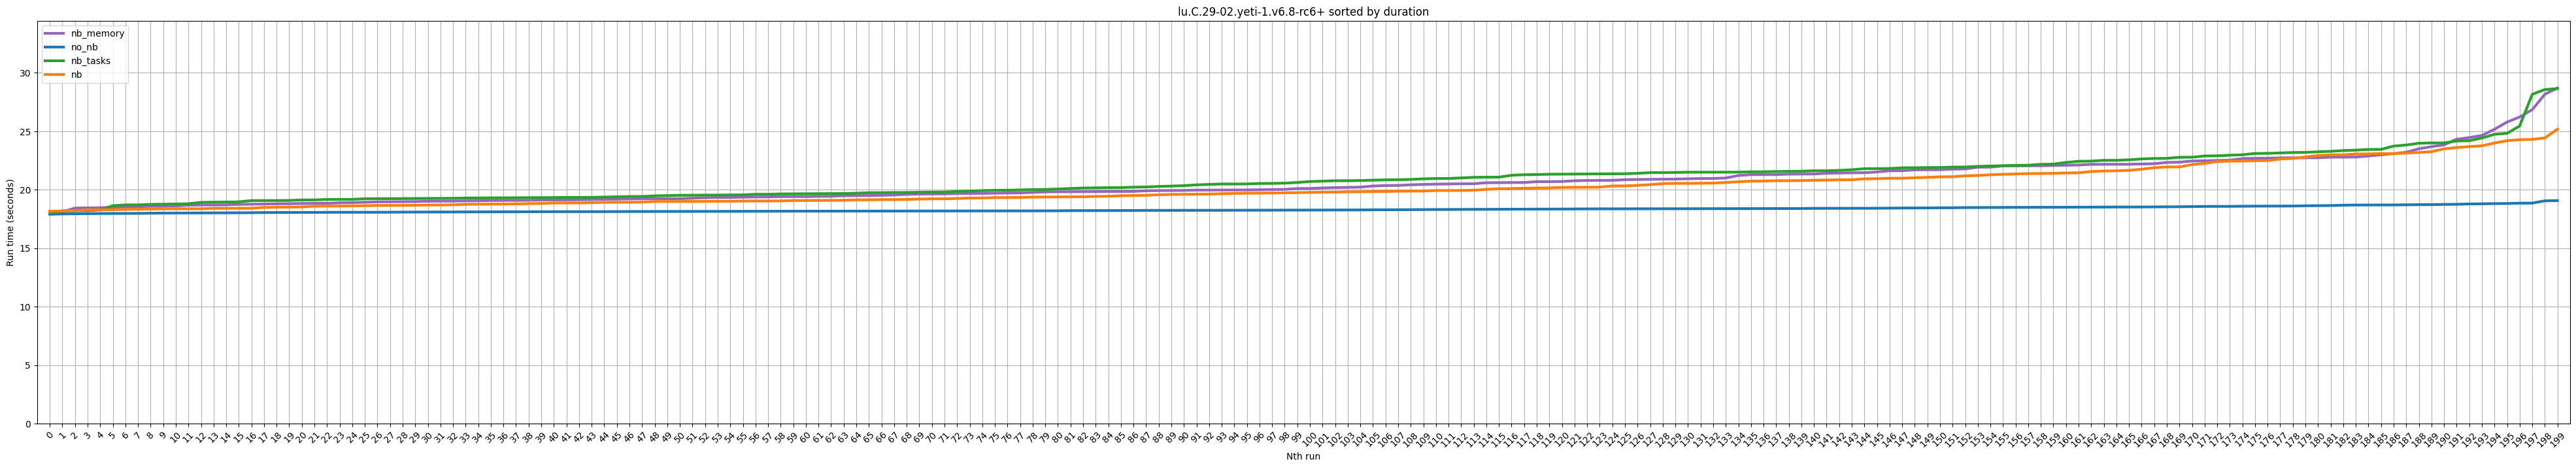

In [15]:
plot_trace_cmd_benchmark_dir("lu.C.29-02.yeti-1.v6.8-rc6+", show_run_index=False, sort_by='duration')

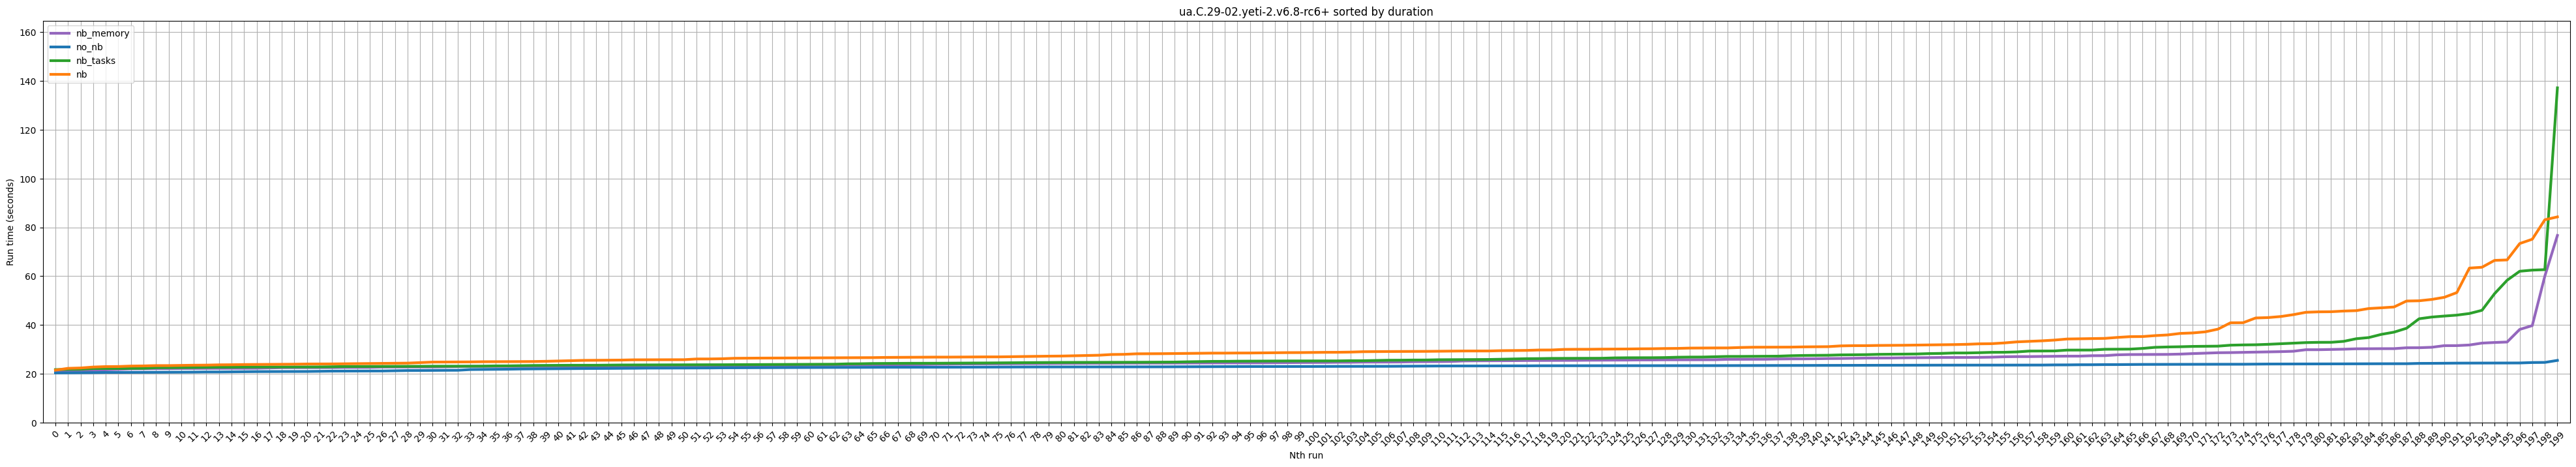

In [16]:
plot_trace_cmd_benchmark_dir("ua.C.29-02.yeti-2.v6.8-rc6+", show_run_index=False, sort_by='duration')

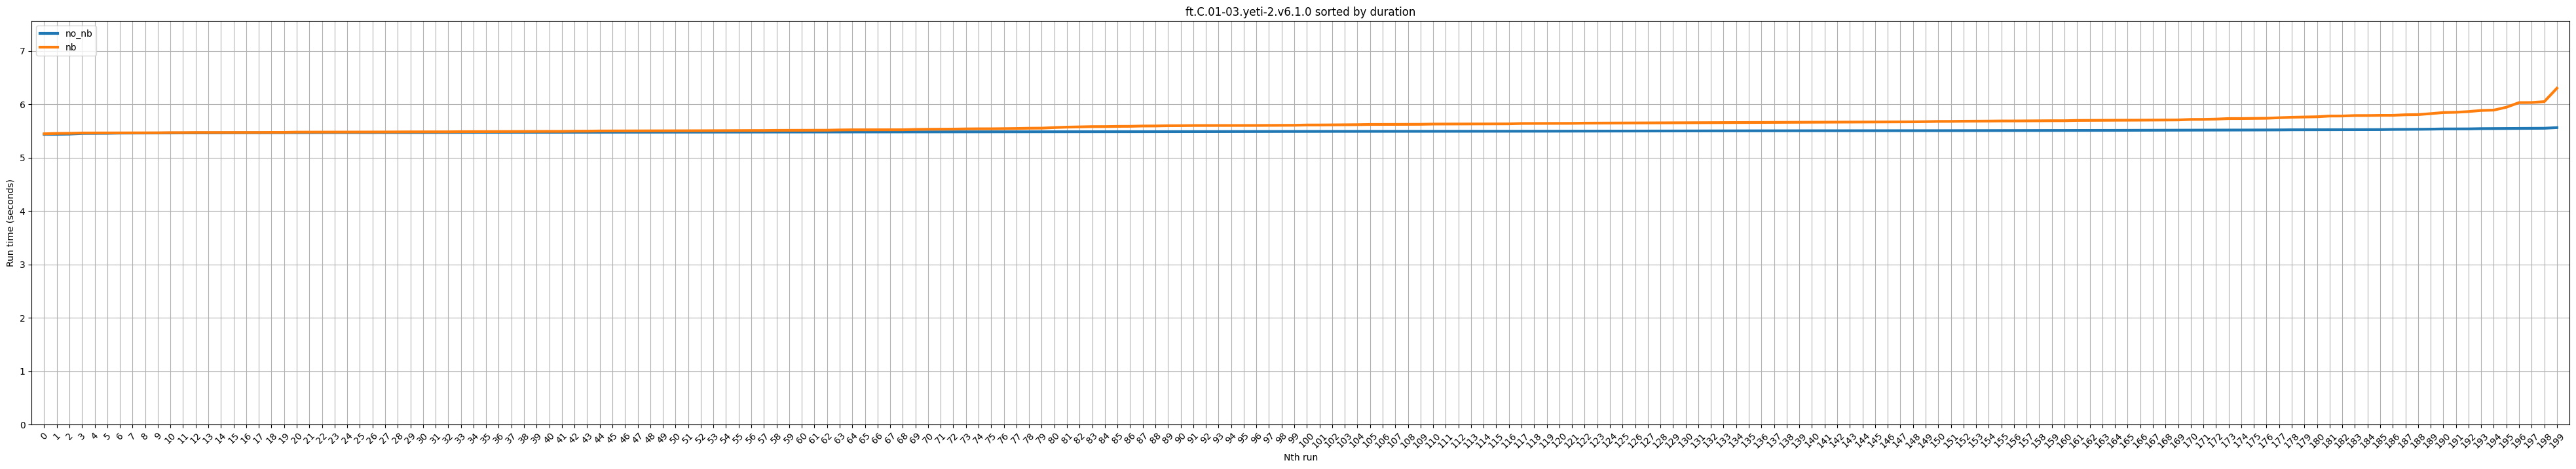

In [17]:
plot_trace_cmd_benchmark_dir("ft.C.01-03.yeti-2.v6.1.0", show_run_index=False, sort_by='duration')

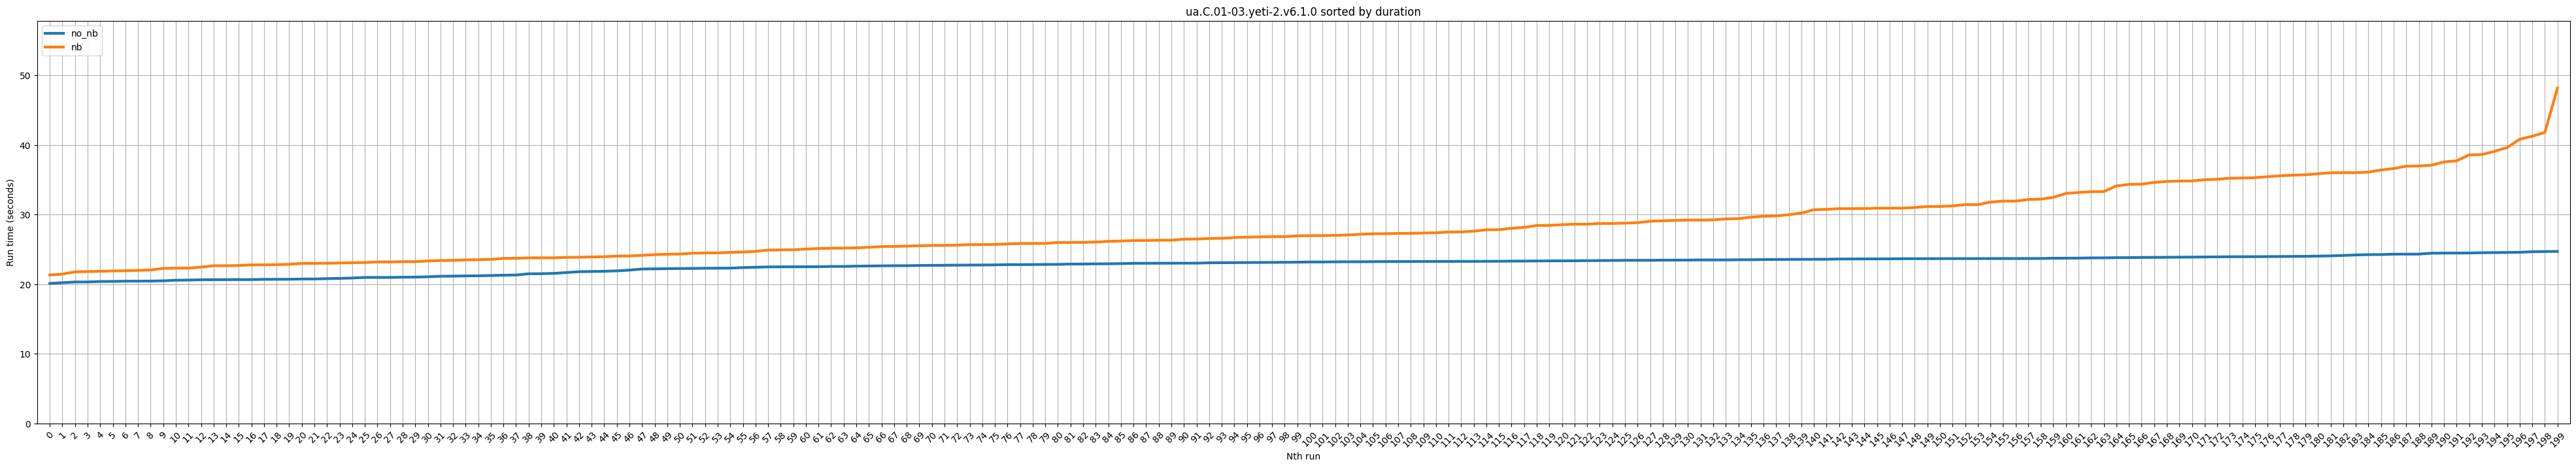

In [18]:
plot_trace_cmd_benchmark_dir("ua.C.01-03.yeti-2.v6.1.0", show_run_index=False, sort_by='duration')

bt.B.dahu-17.v6.8-rc3


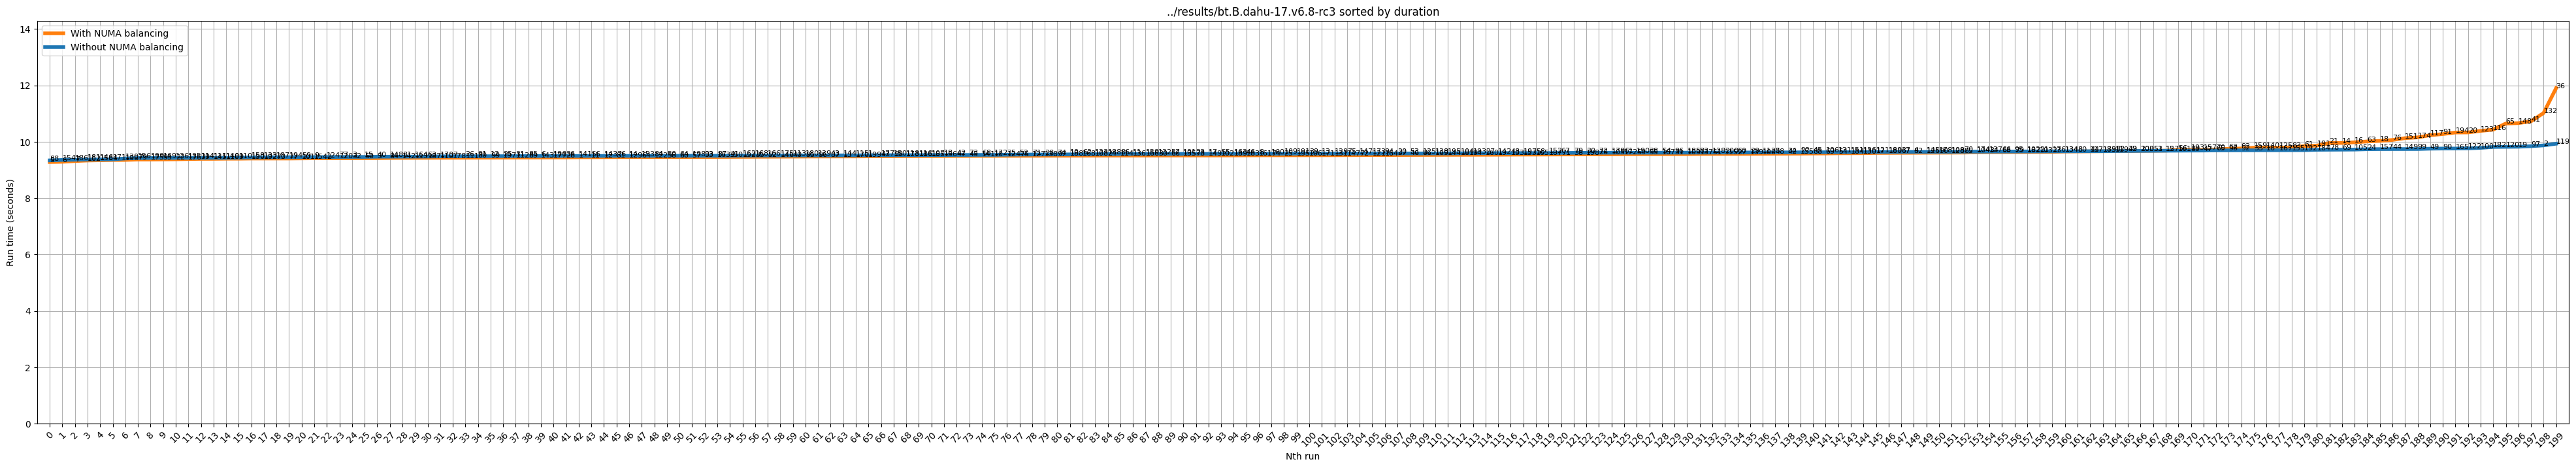

bt.C.dahu-28.v6.8-rc3


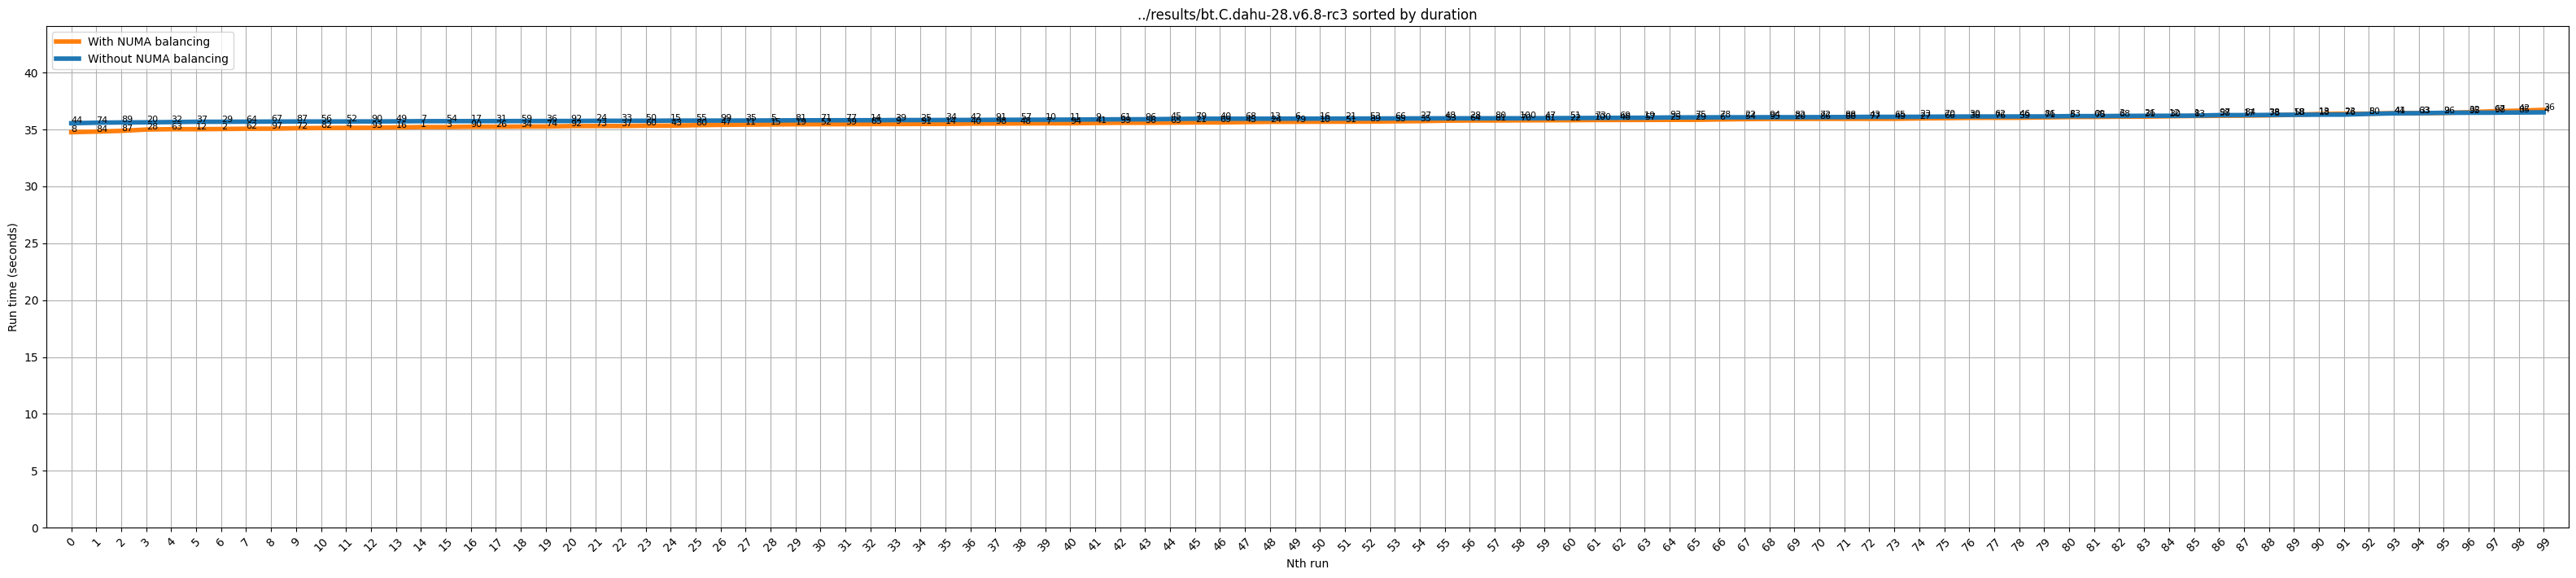

cg.C.26-02--2.servan-2.v6.8-rc3


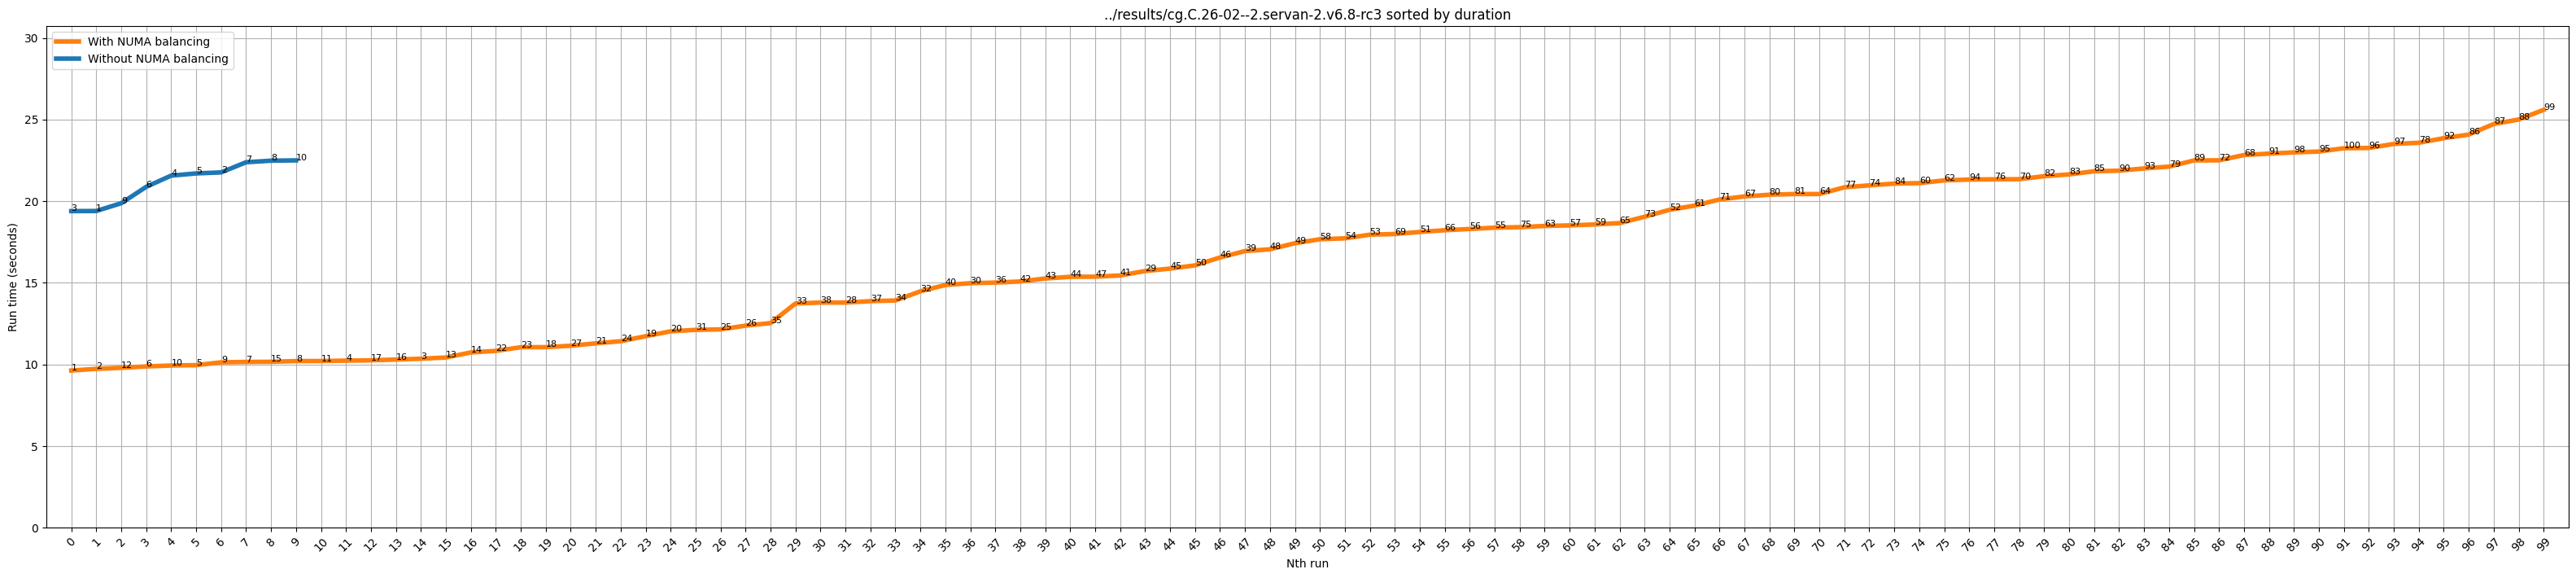

cg.C.26-02.servan-2.v6.8-rc3


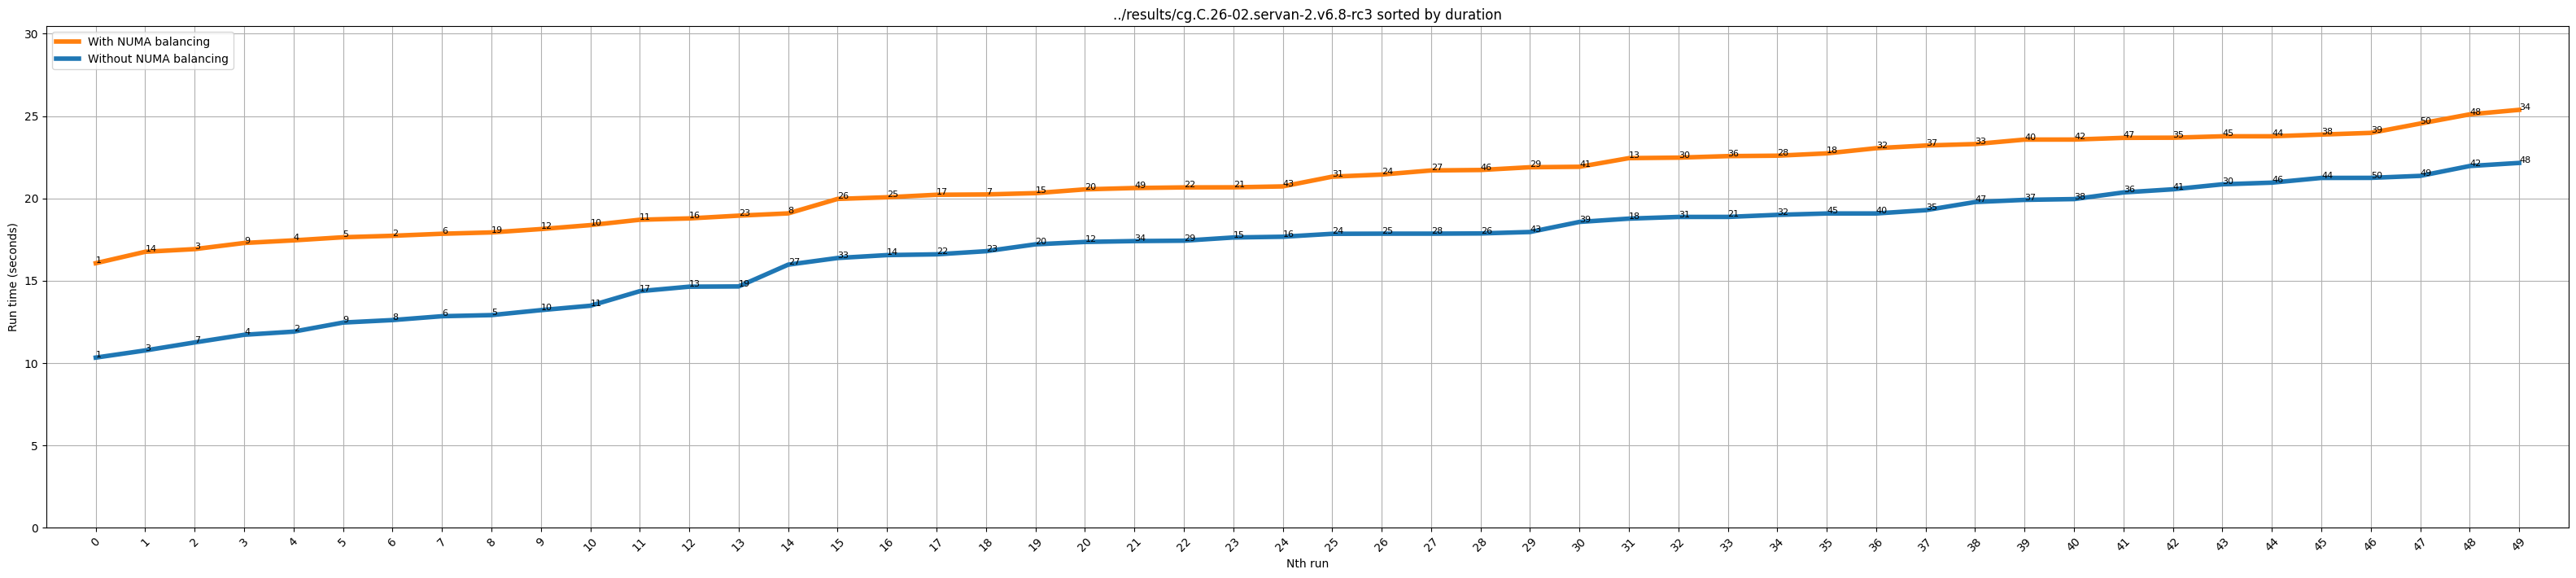

cg.C.and.bt.B.servan-2.v6.8-rc3


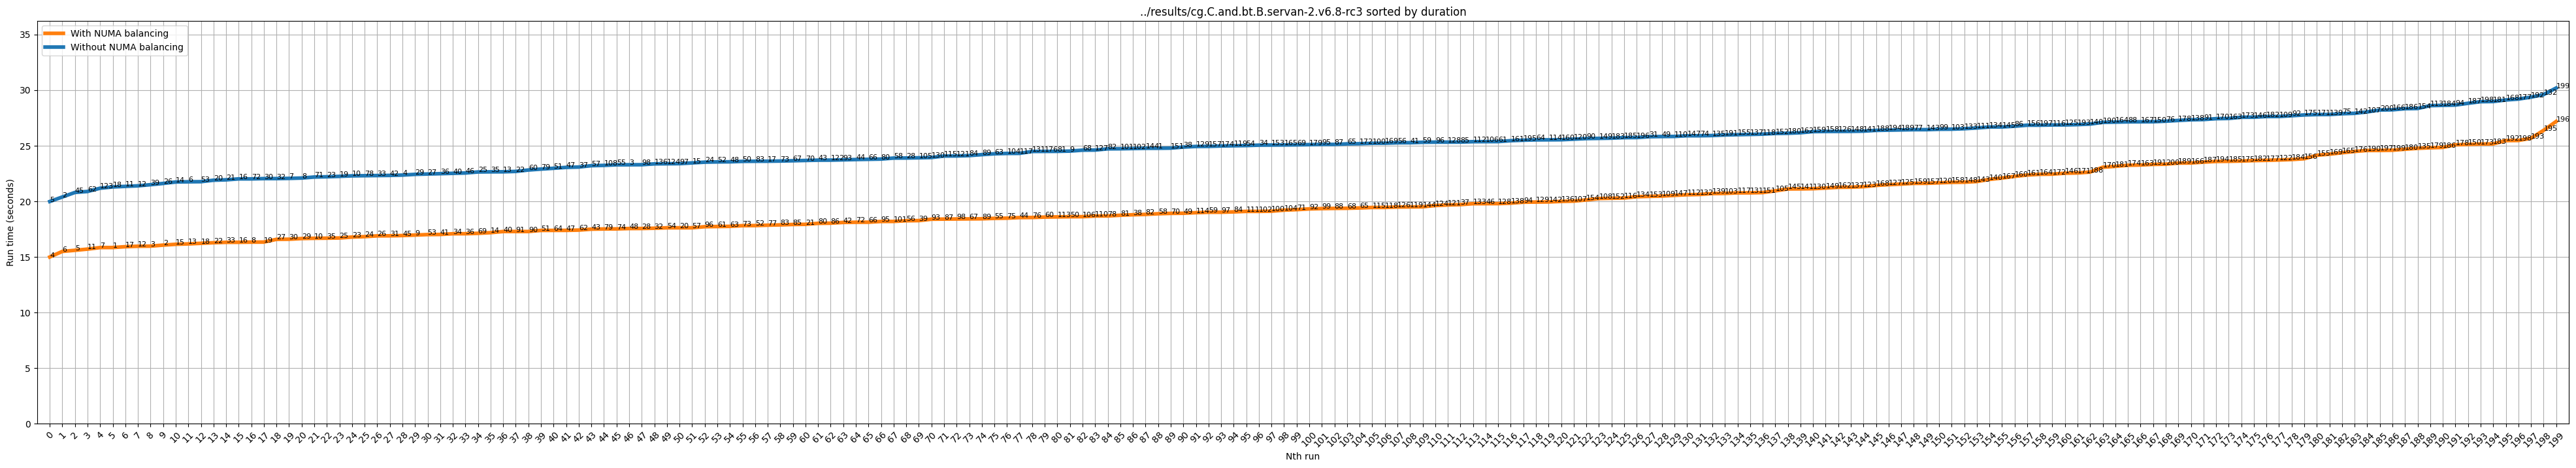

cg.C.servan-1.v6.8-rc3


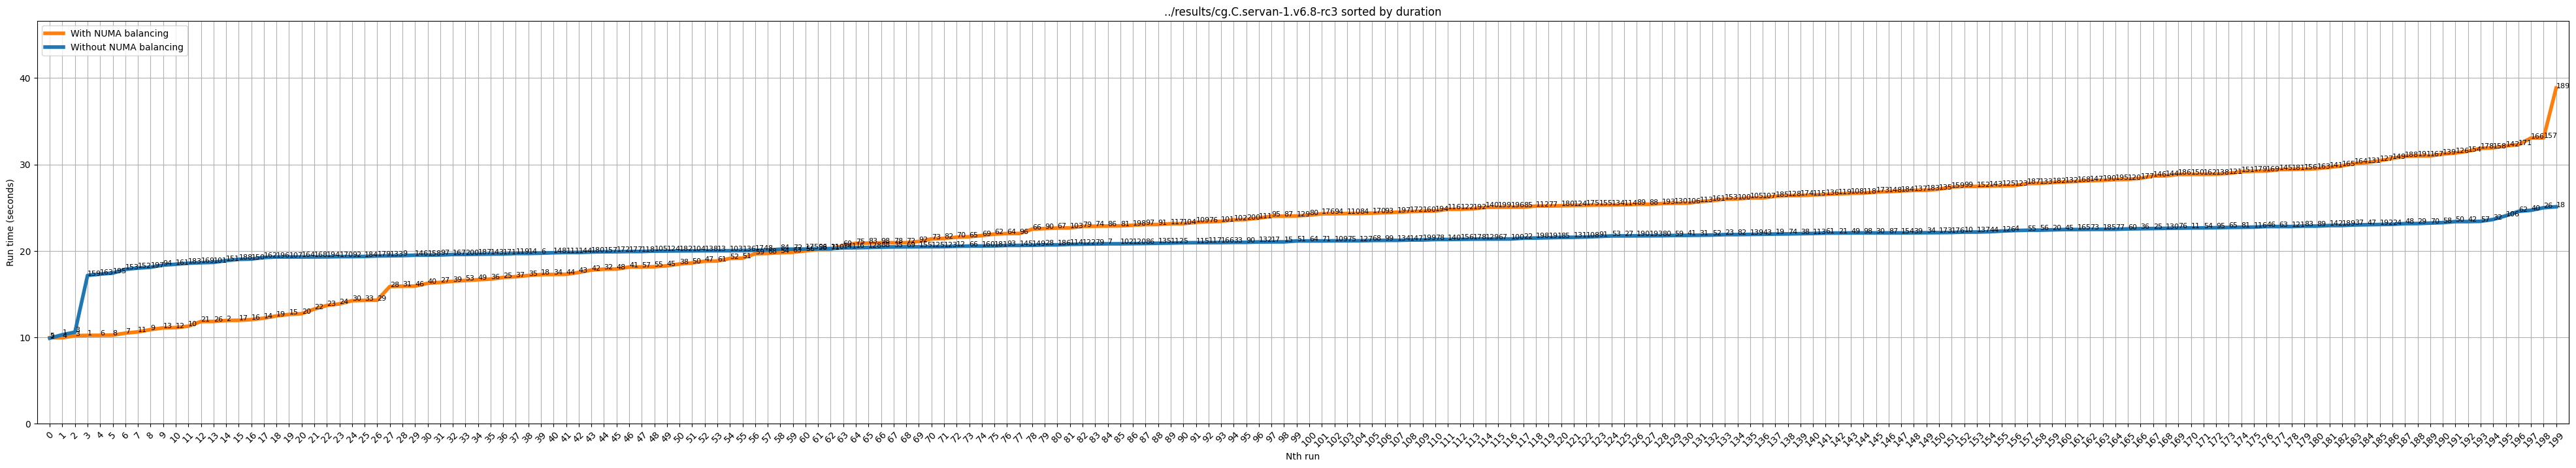

cg.C.servan-2.thermal2.v6.8-rc3


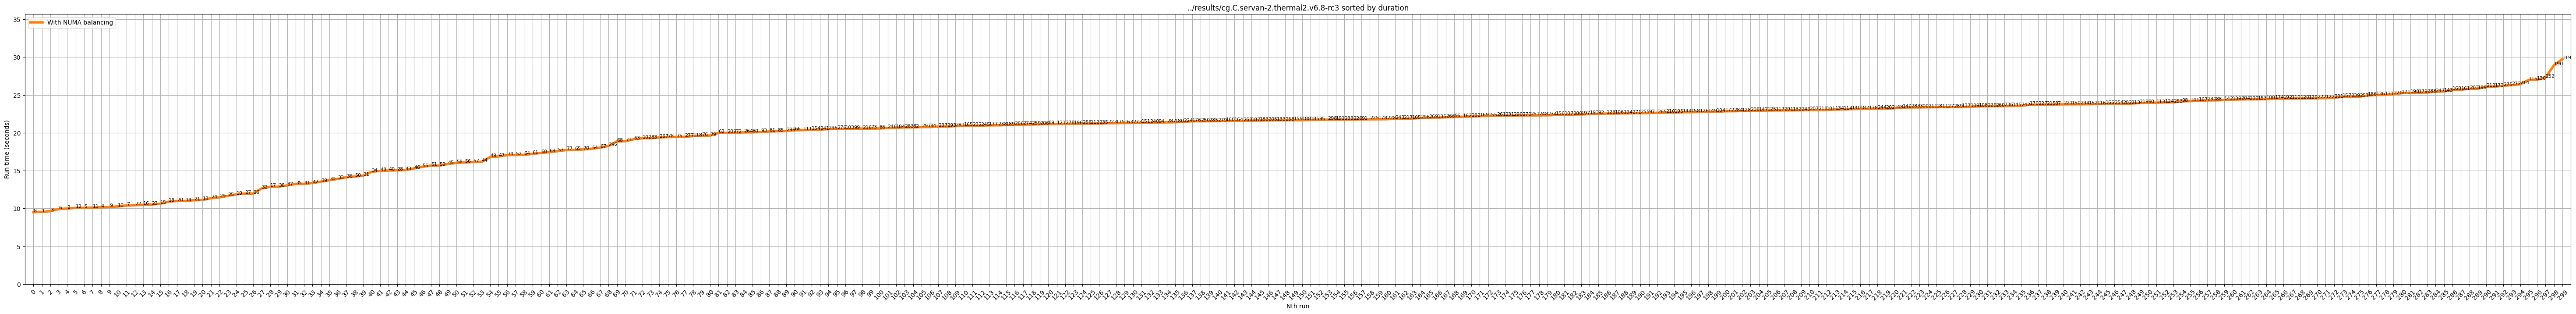

ft.C.yeti-4.v6.8-rc3


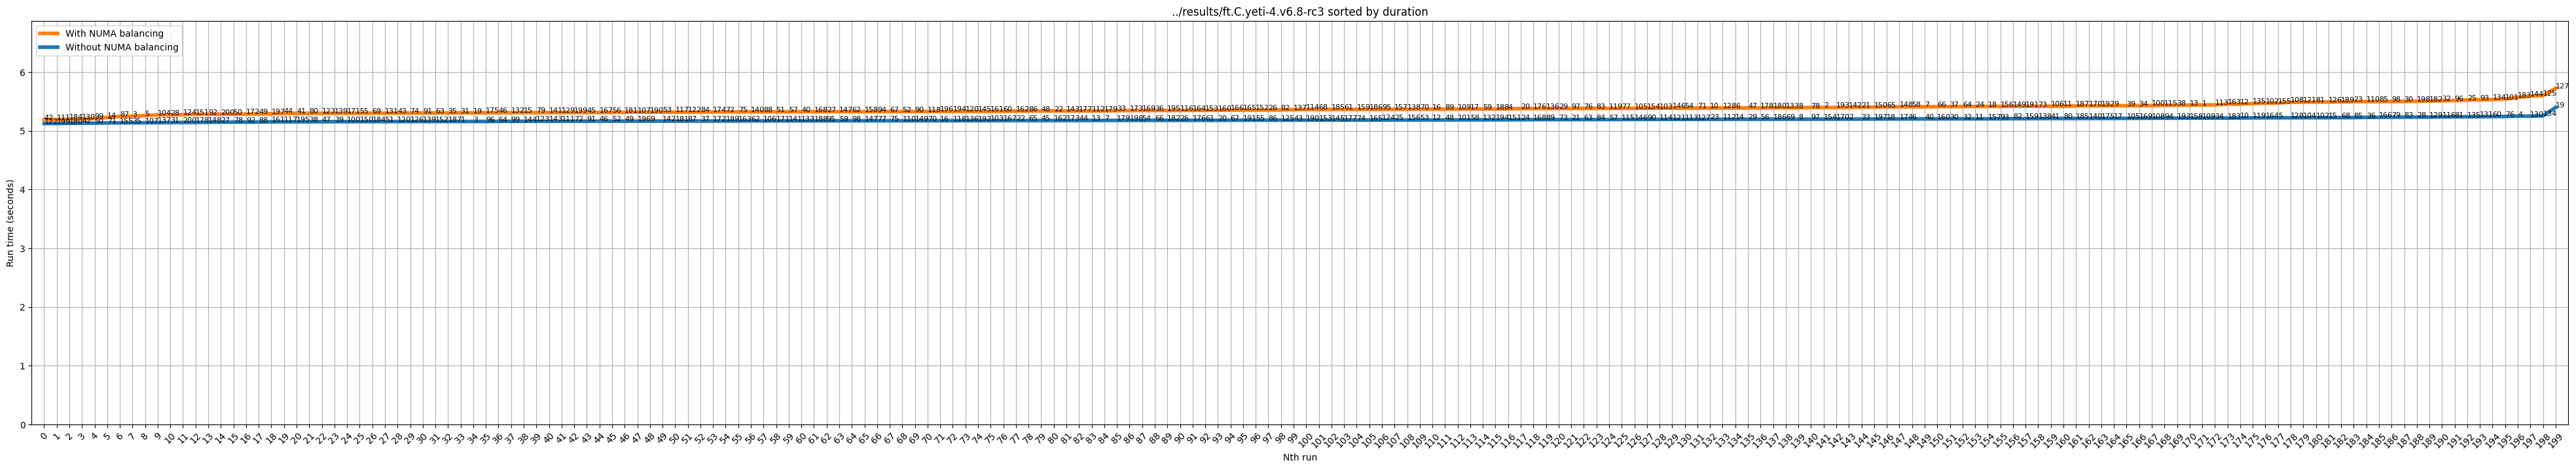

lu.B.27-02.thermal.servan-2.v6.8-rc3


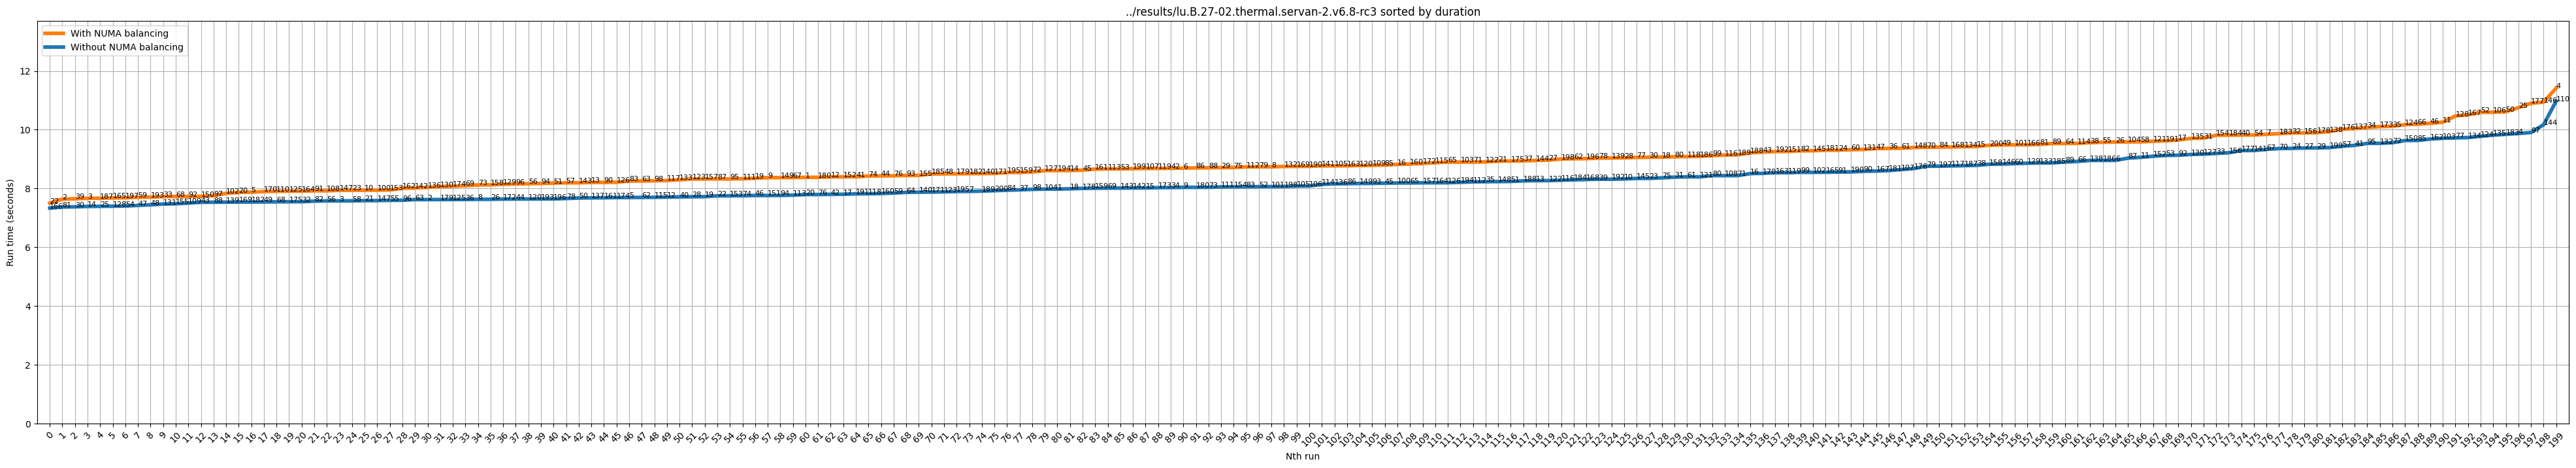

lu.B.dahu-17.v6.8-rc3


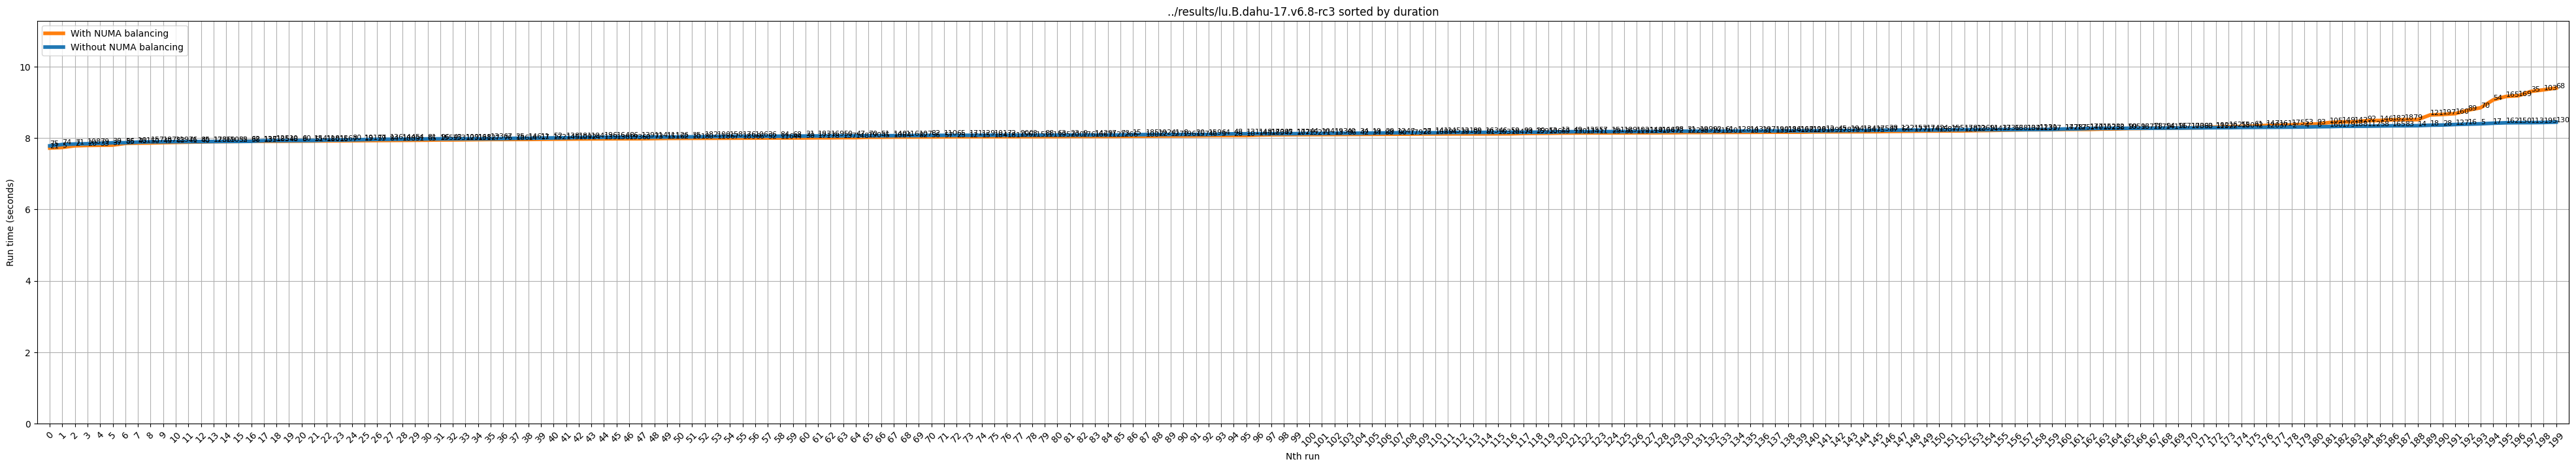

lu.C.dahu-18.v6.8-rc3


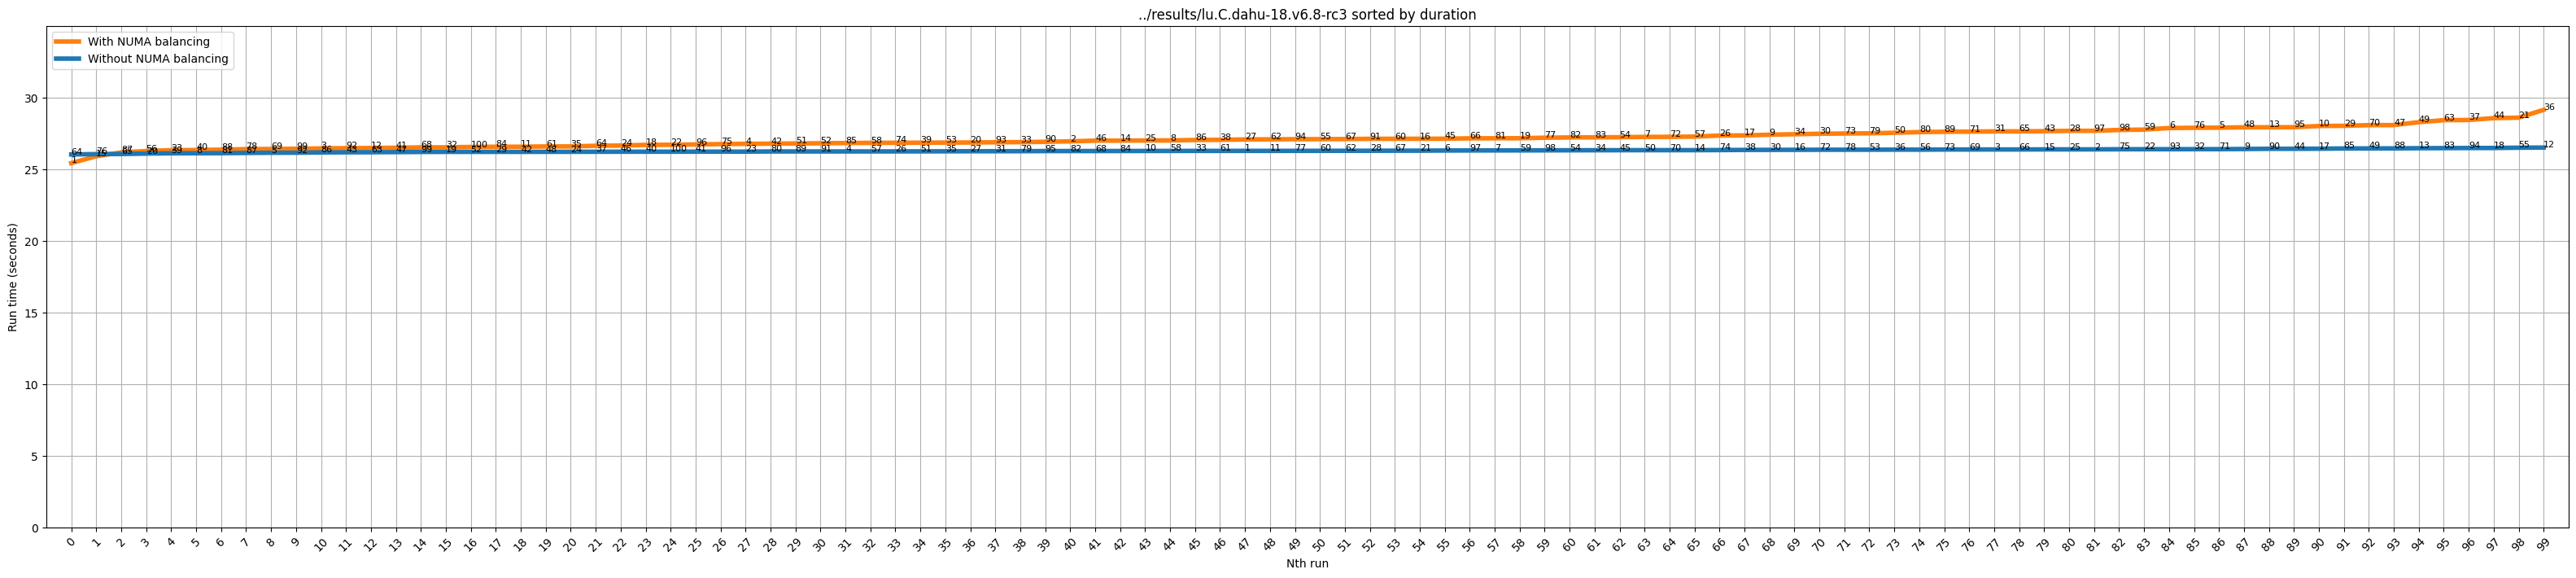

lu.C.yeti-4.v6.8-rc3


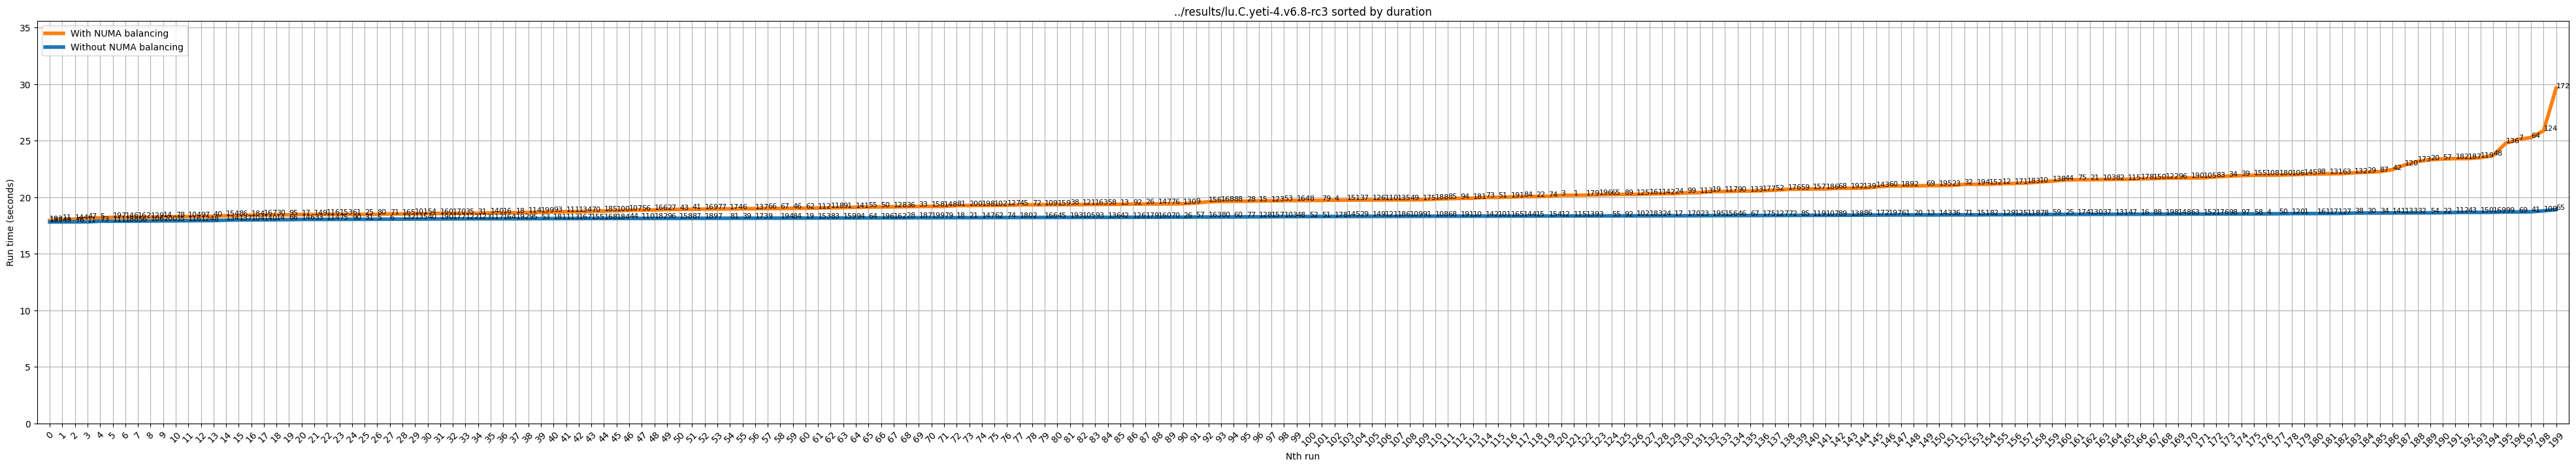

mg.D.28-02.yeti-1.v6.8-rc3


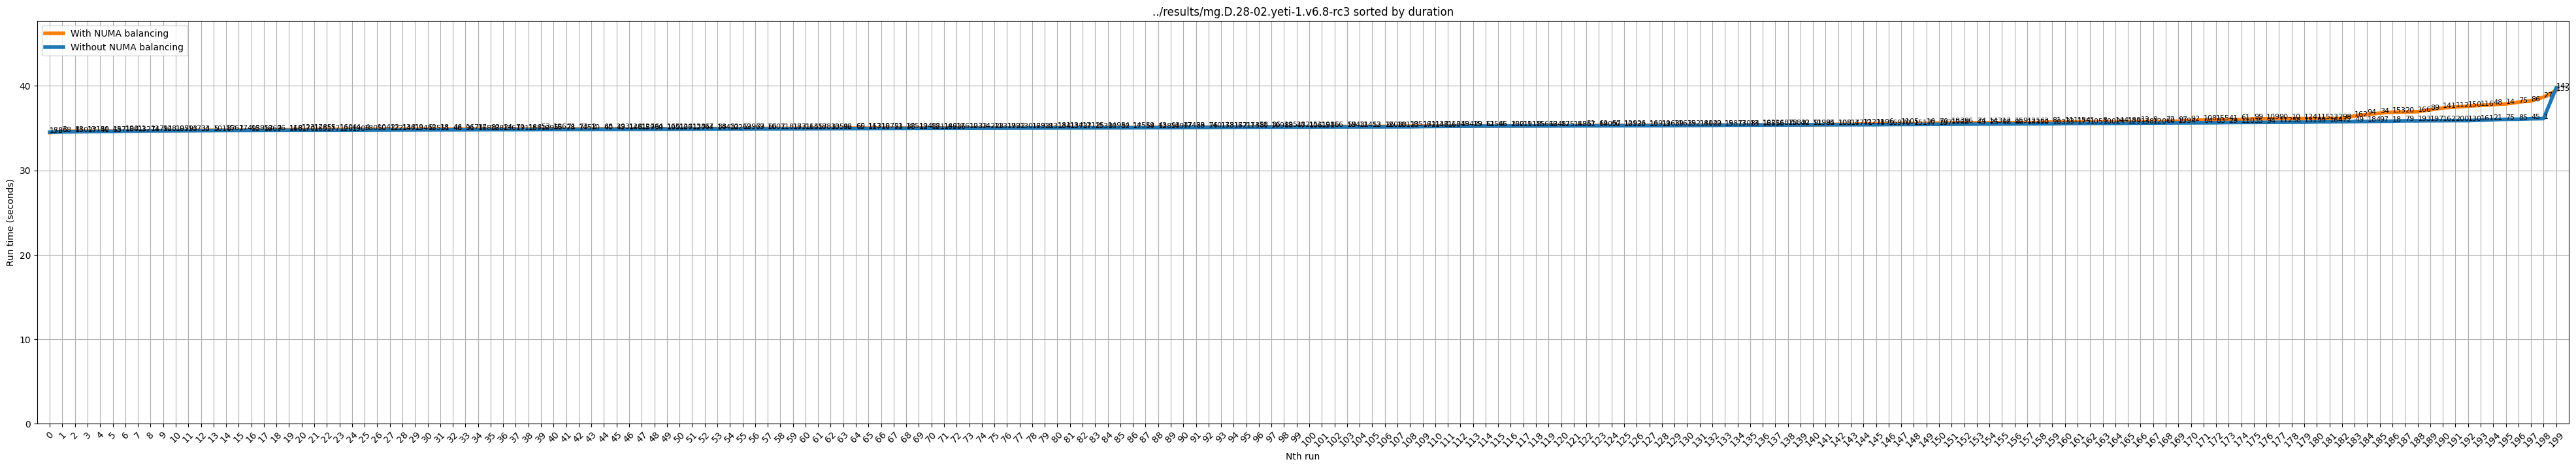

ua.C.28-02.yeti-3.v6.8-rc3


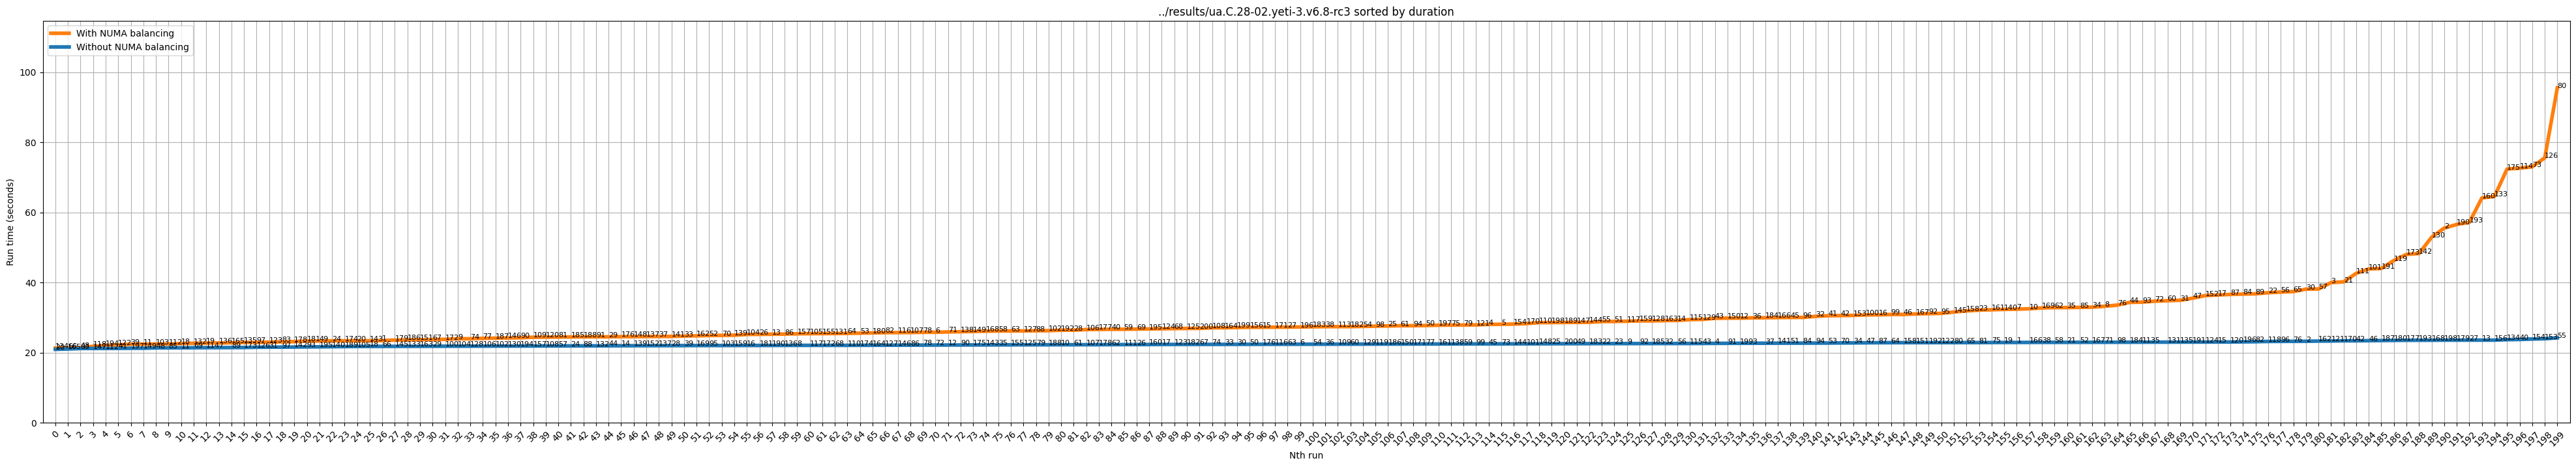

Done


In [12]:
for dir in trace_cmd_benchmark_dirs :
    if not dir.endswith('rc3'):
        continue
    benchmark_dir = get_result_dir_path(dir)
    print(dir)
    plot_trace_cmd_benchmark_dir(benchmark_dir, show_run_index=True, sort_by='duration')
print("Done")

#### Kernel v6.1.0-17

bt.B.29-02.dahu-2.v6.1.0-17


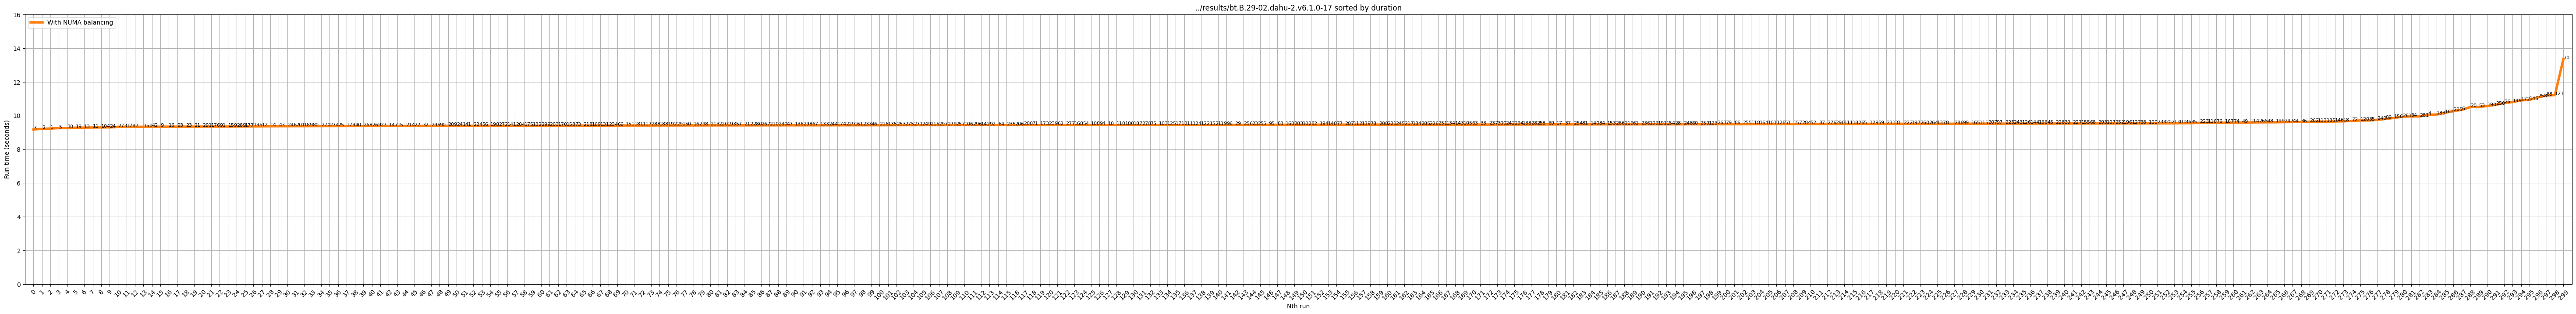

bt.C.dahu.v6.1.0-17


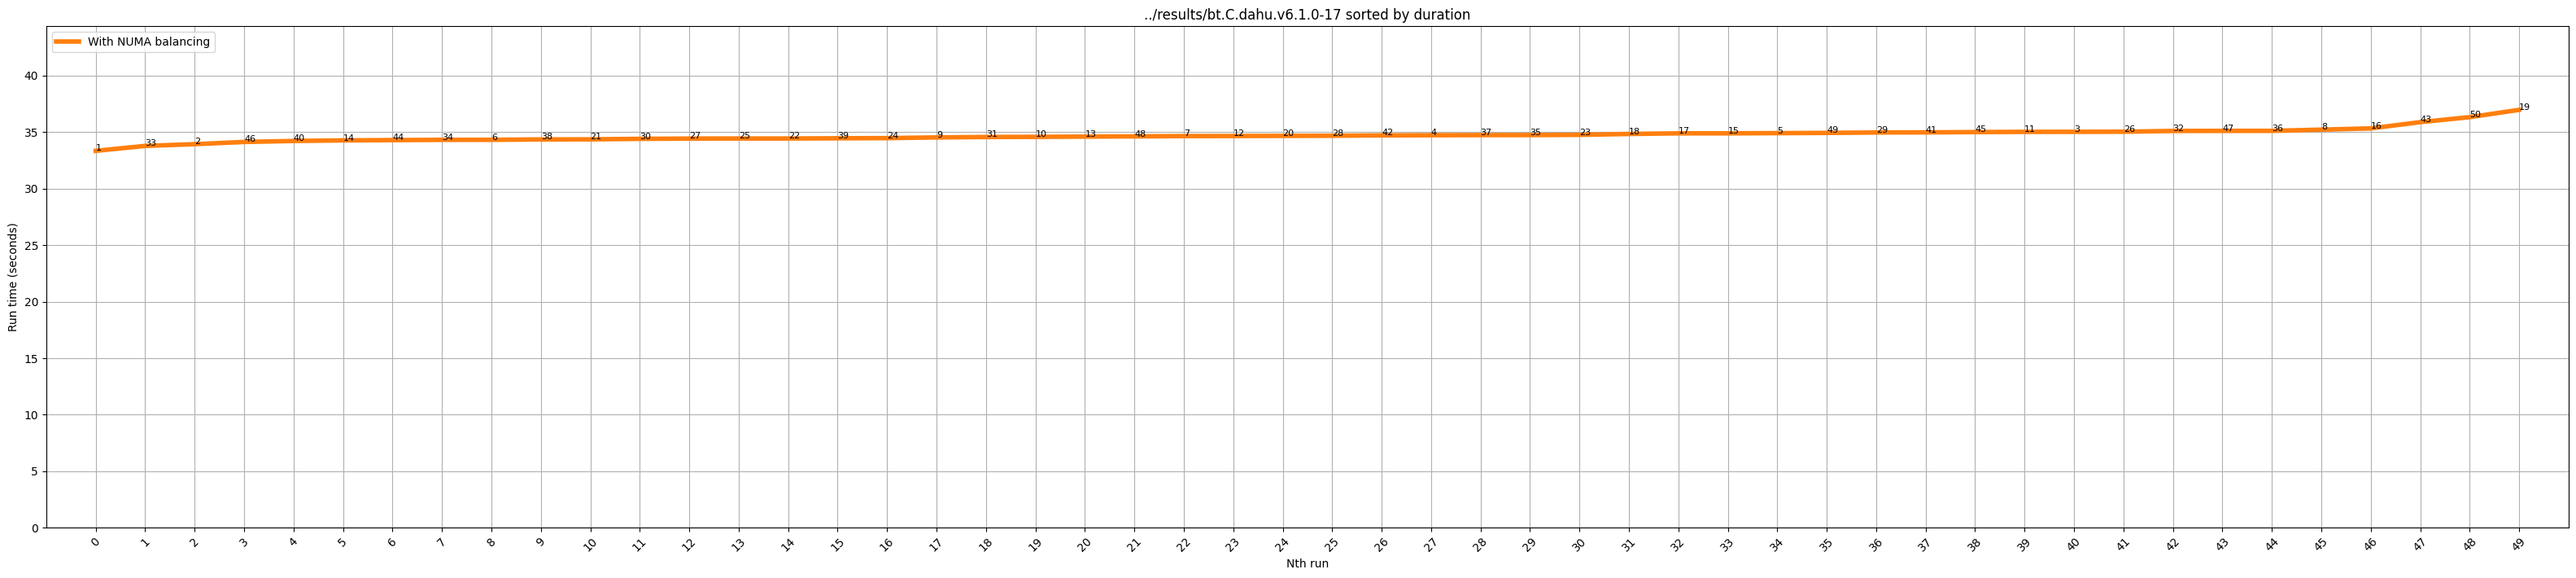

bt.C.yeti.v6.1.0-17


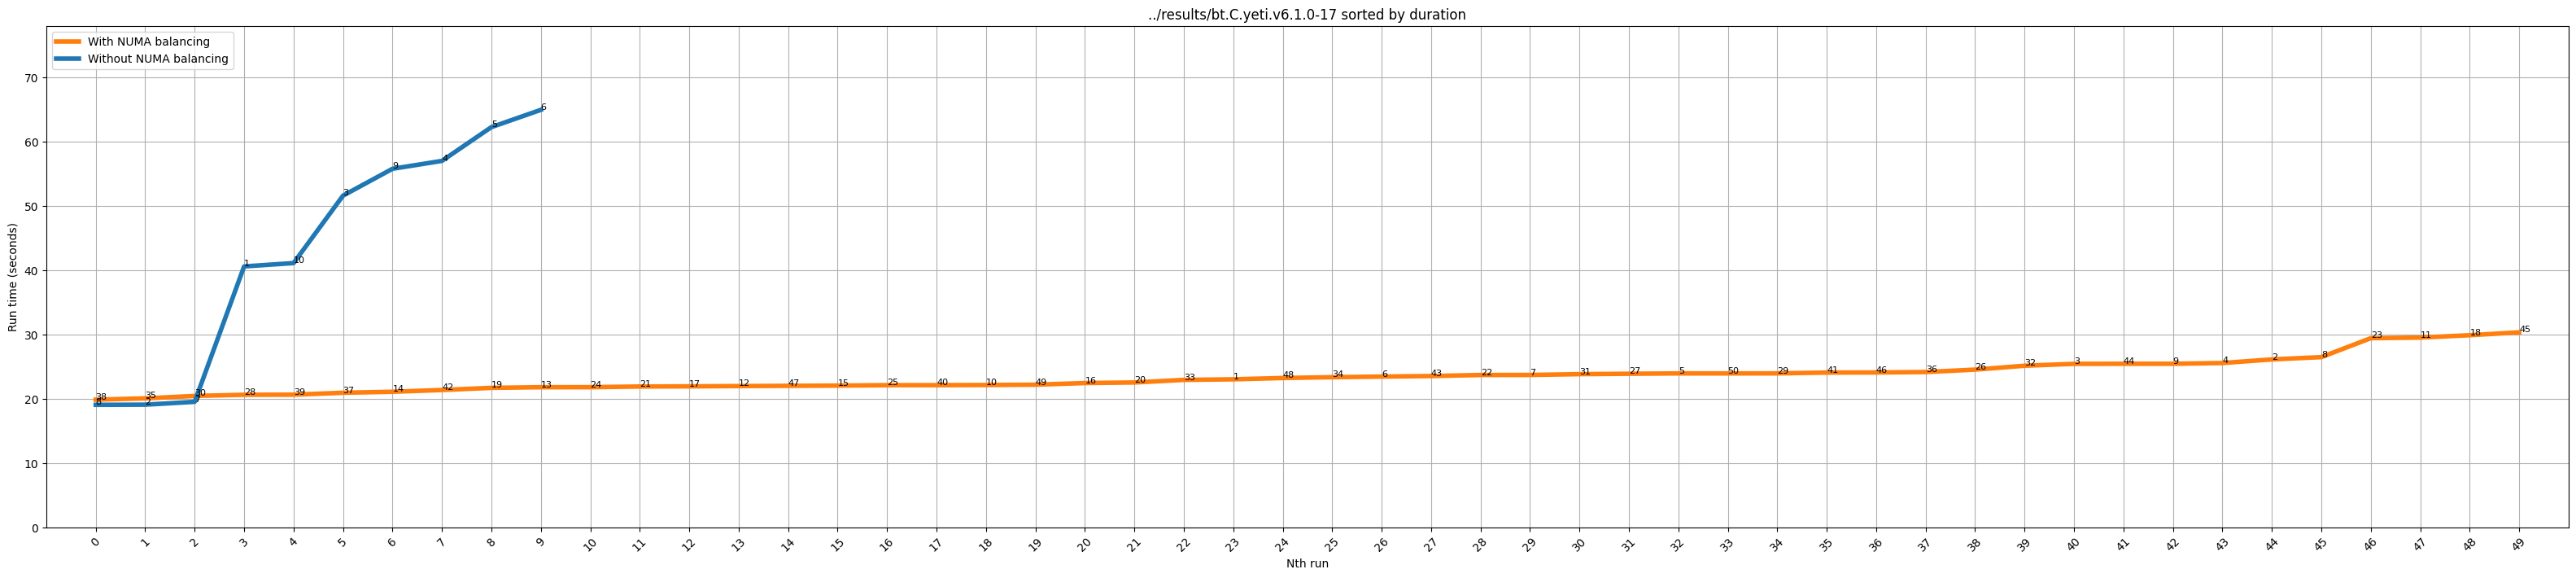

cg.C.servan-2.v6.1.0-17


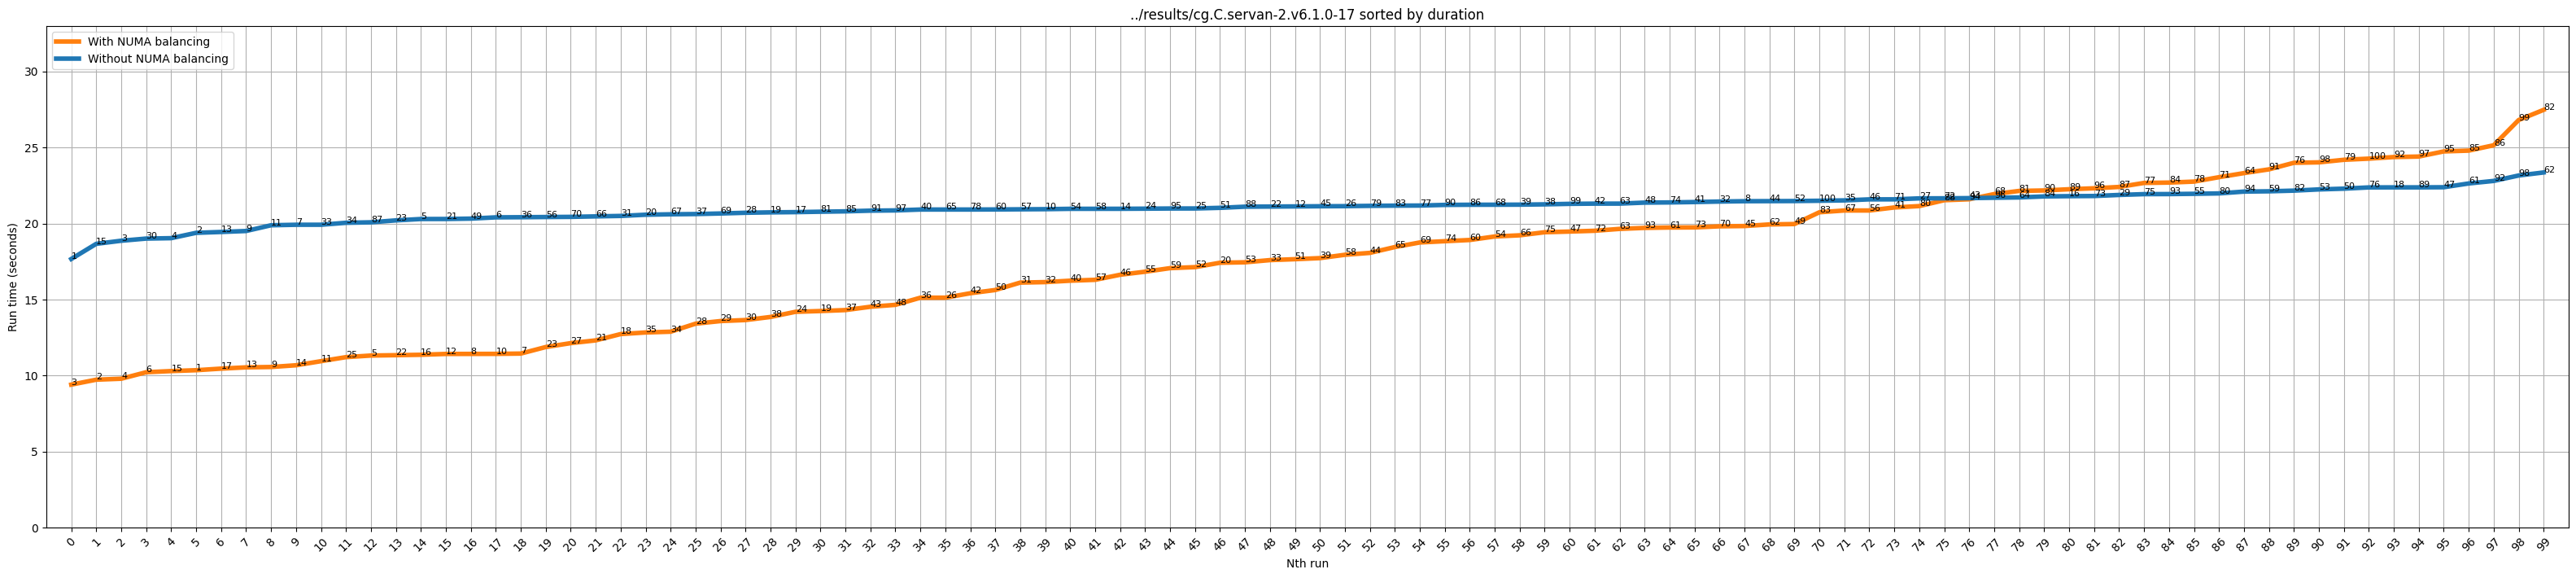

cg.C.servan.v6.1.0-17


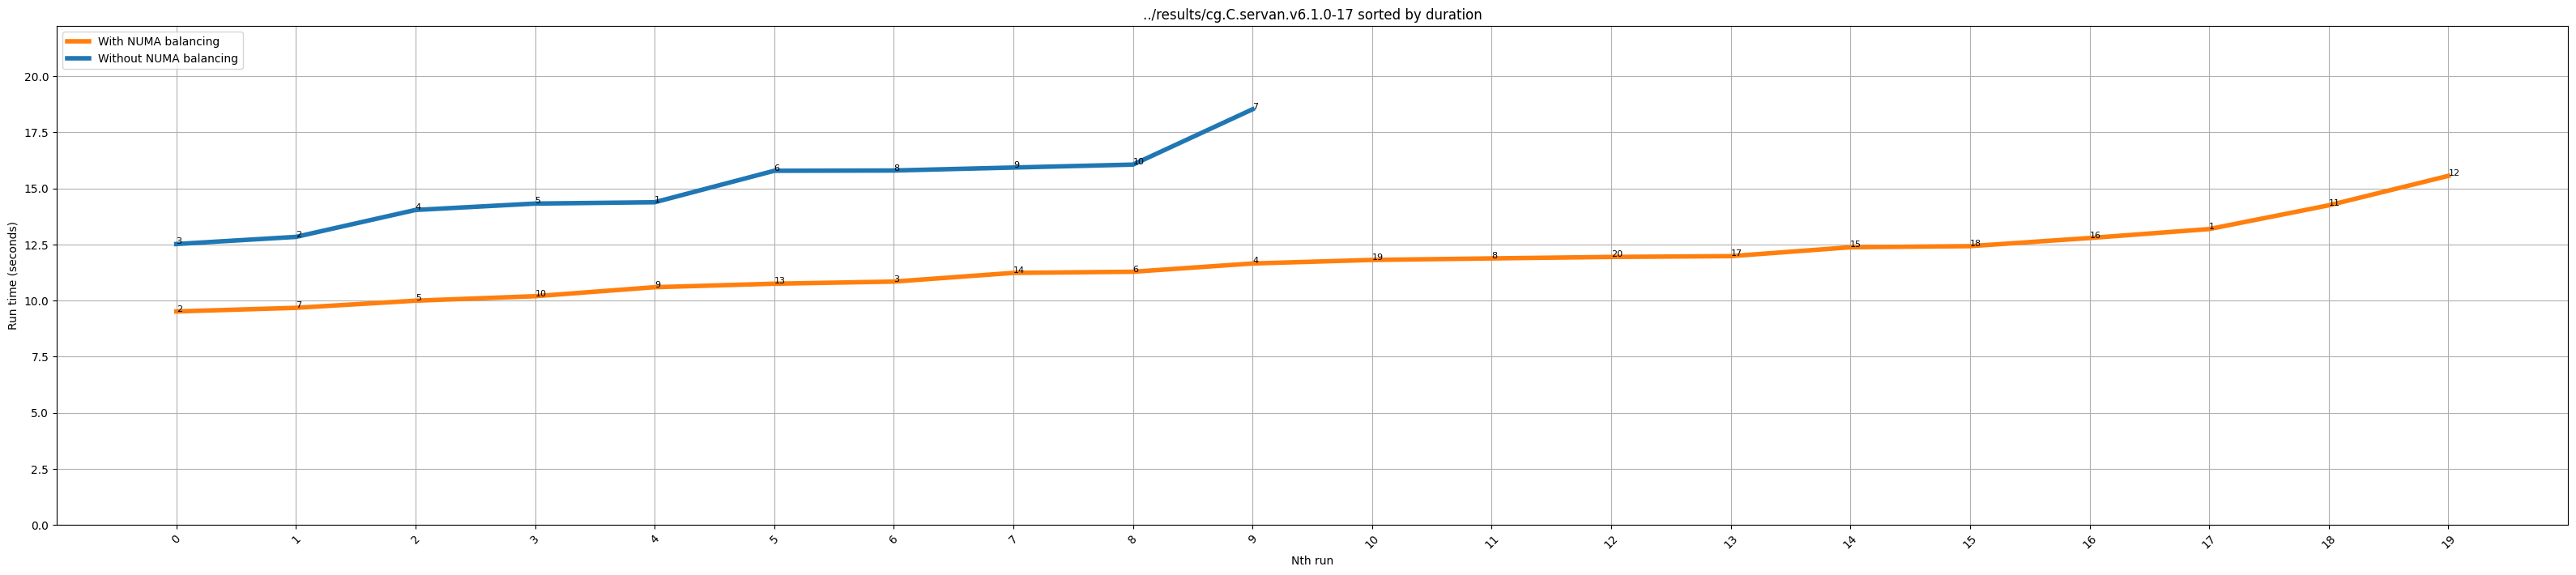

ep.D.dahu.v6.1.0-17


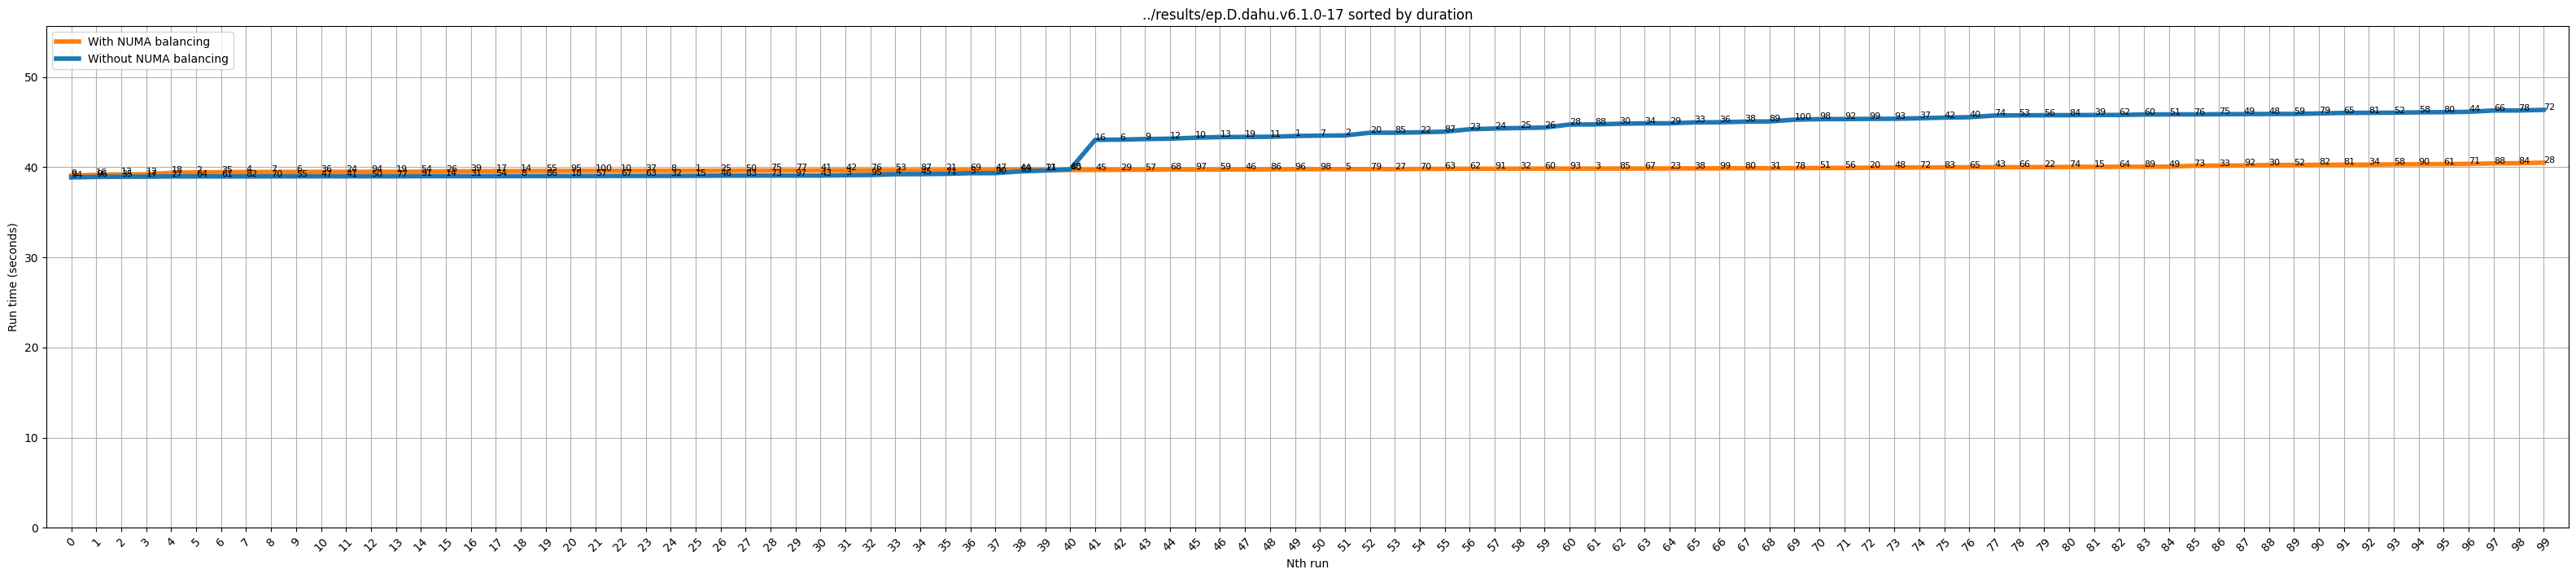

ft.C.dahu.v6.1.0-17


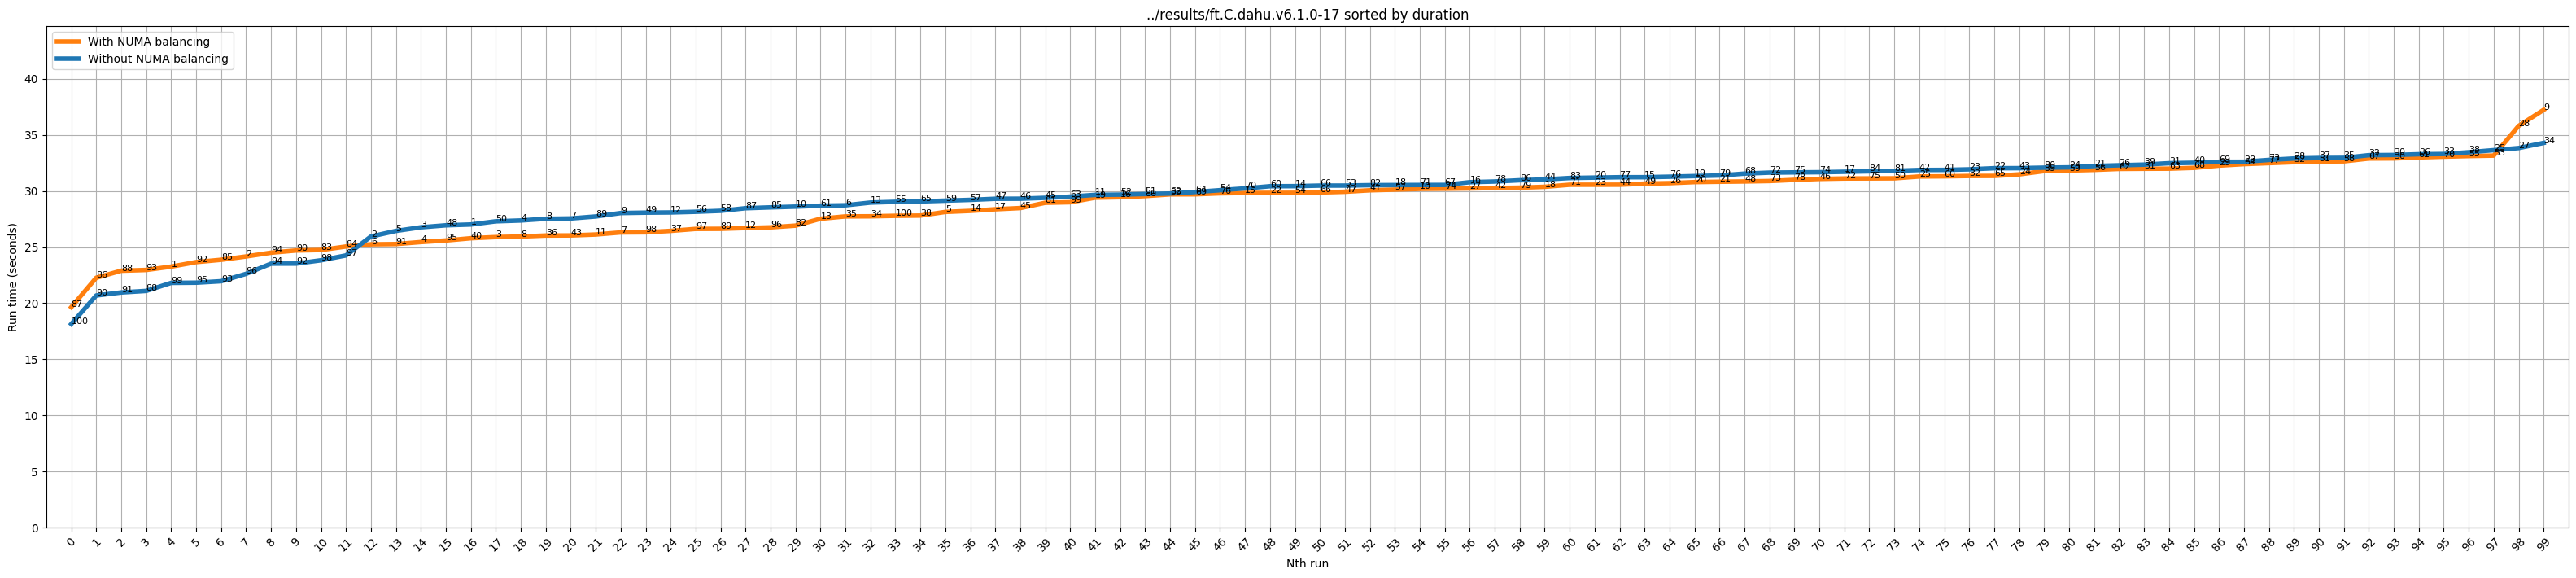

ft.C.yeti-1.v6.1.0-17


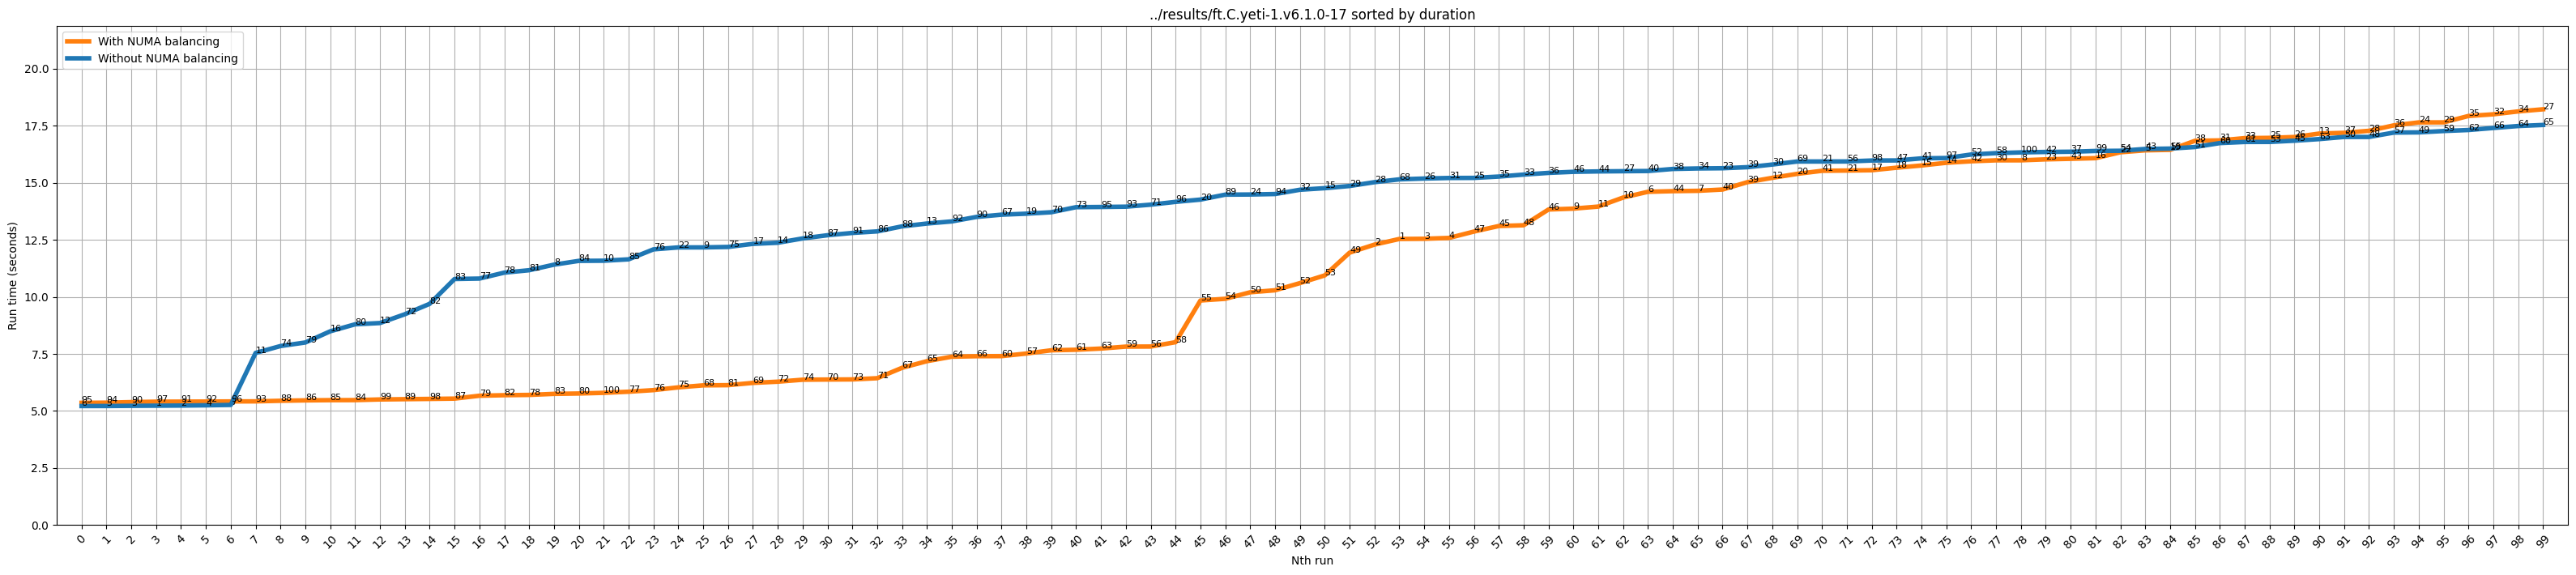

ft.D.yeti.v6.1.0-17


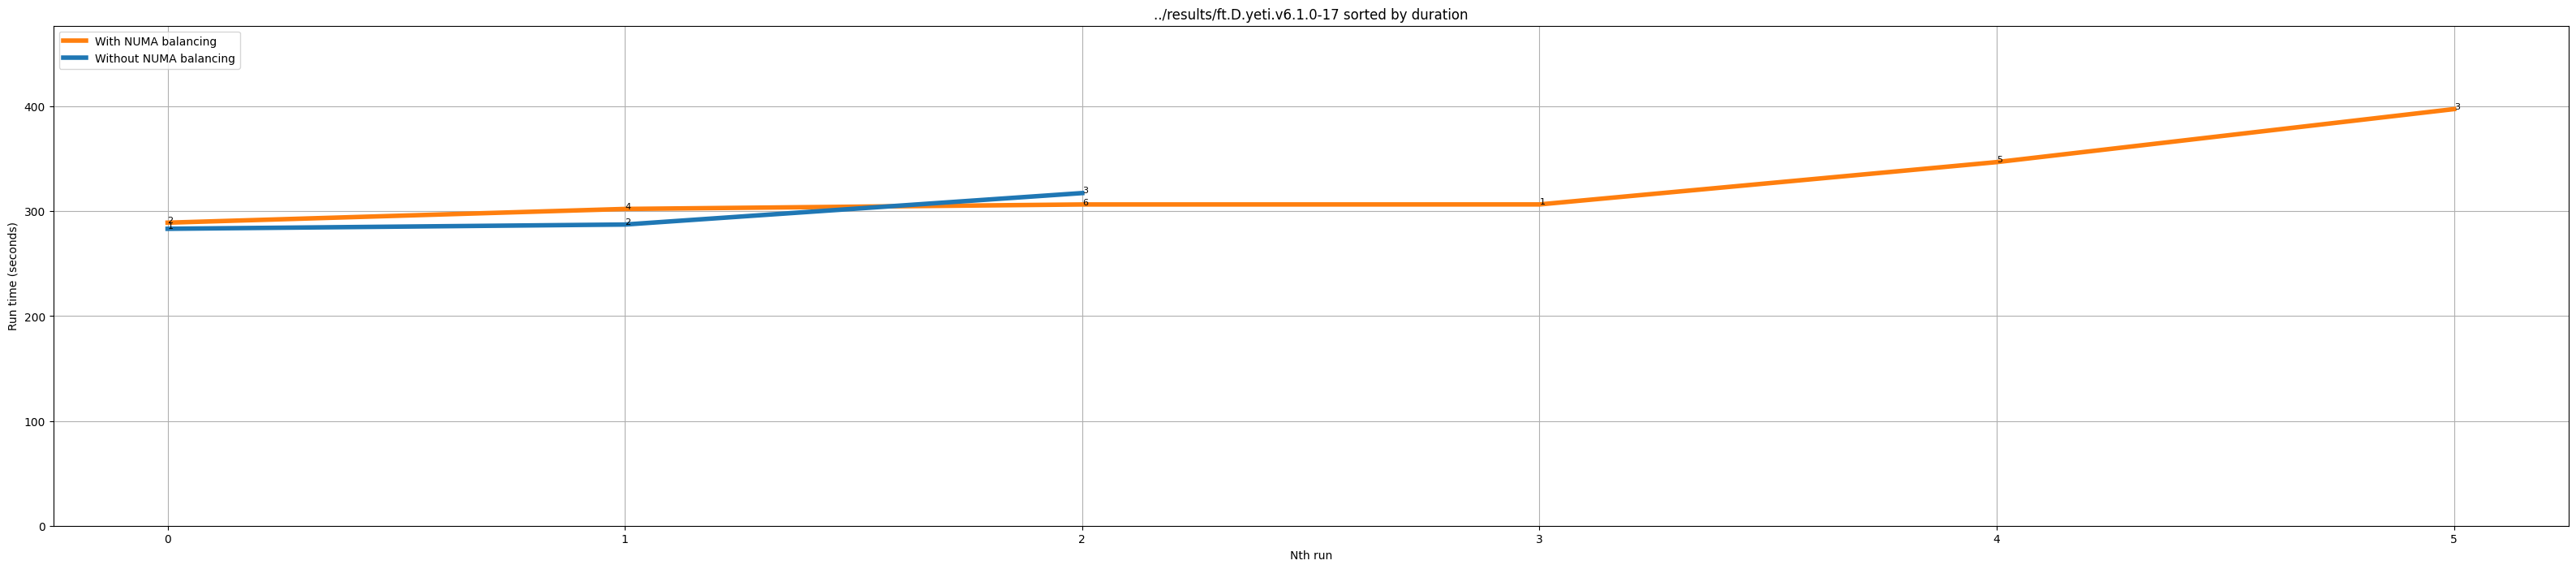

lu.C.dahu-30.v6.1.0-17


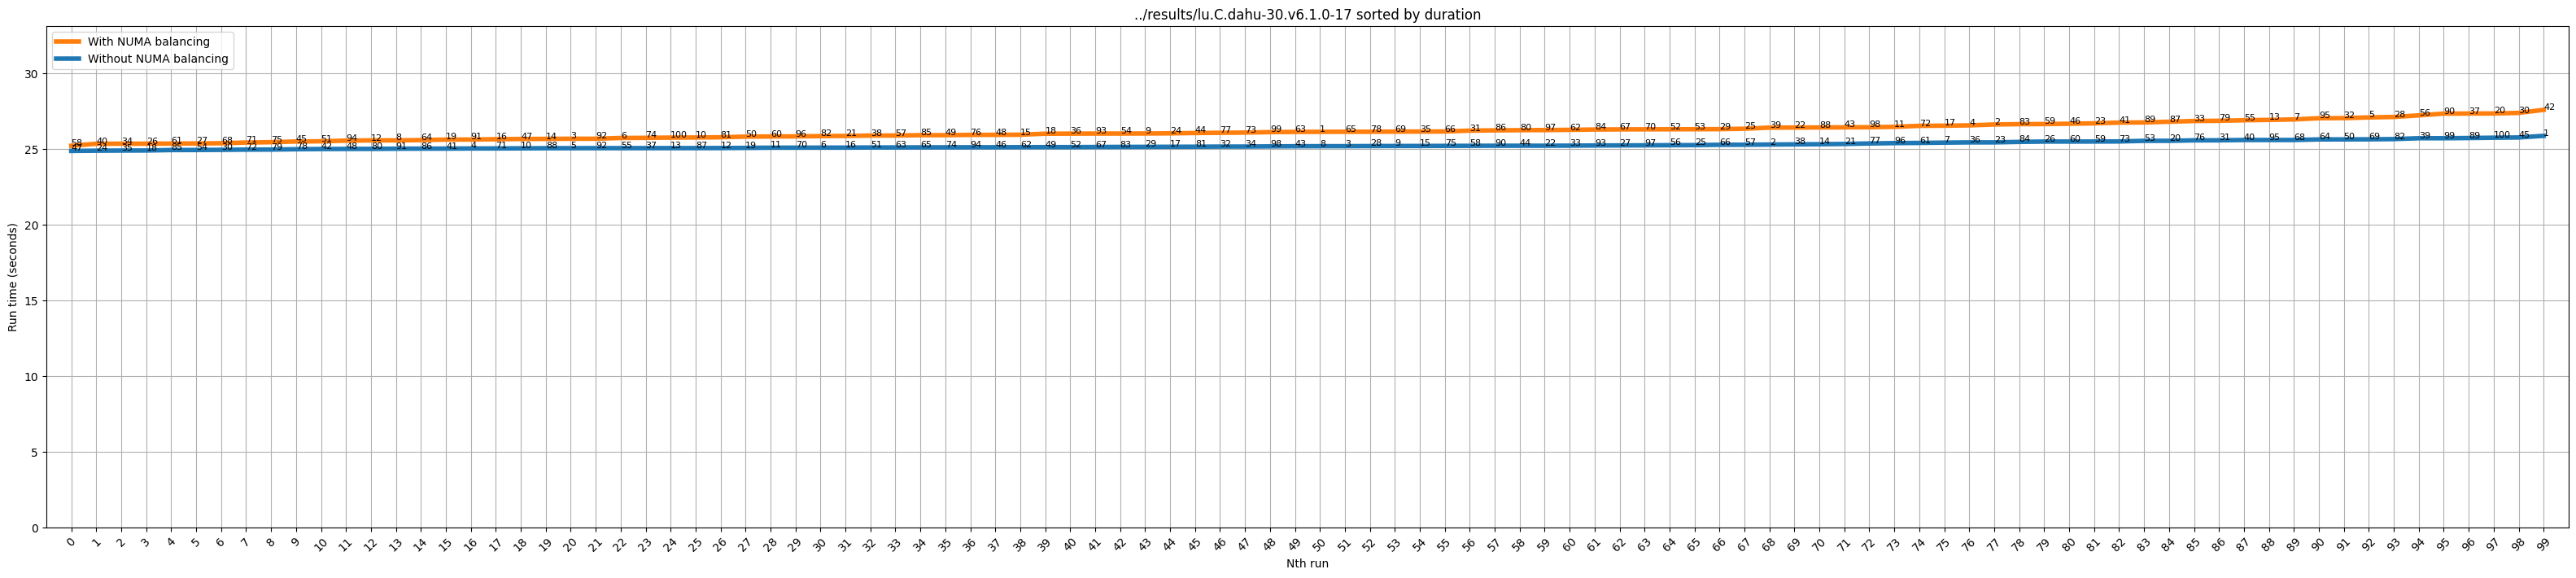

lu.C.dahu.v6.1.0-17


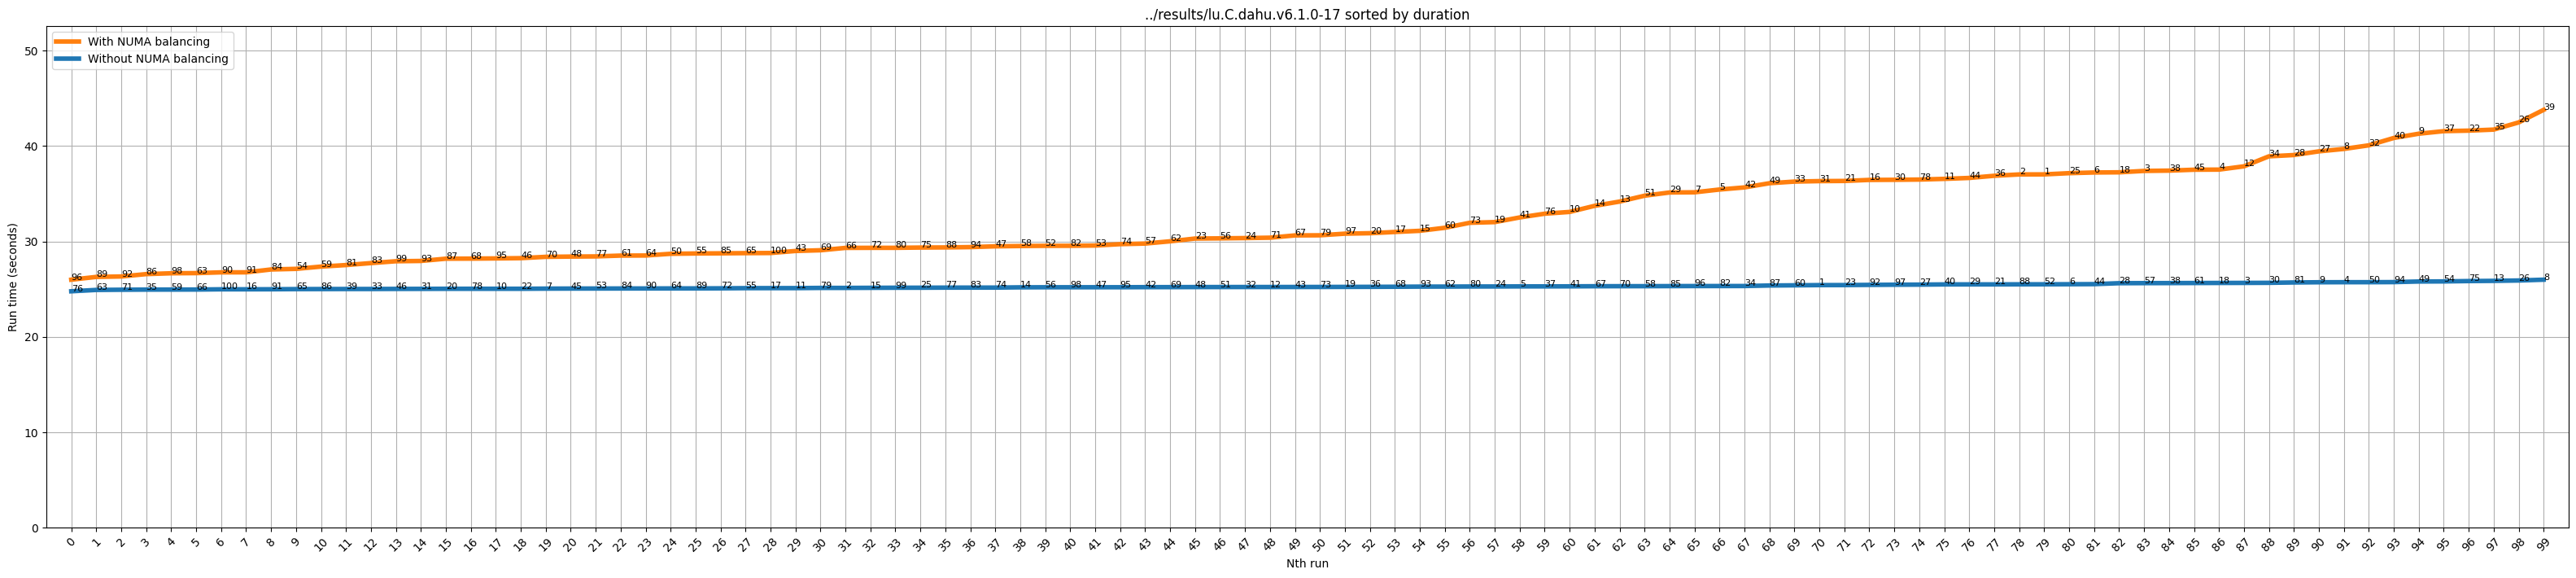

lu.D.yeti.v6.1.0-17


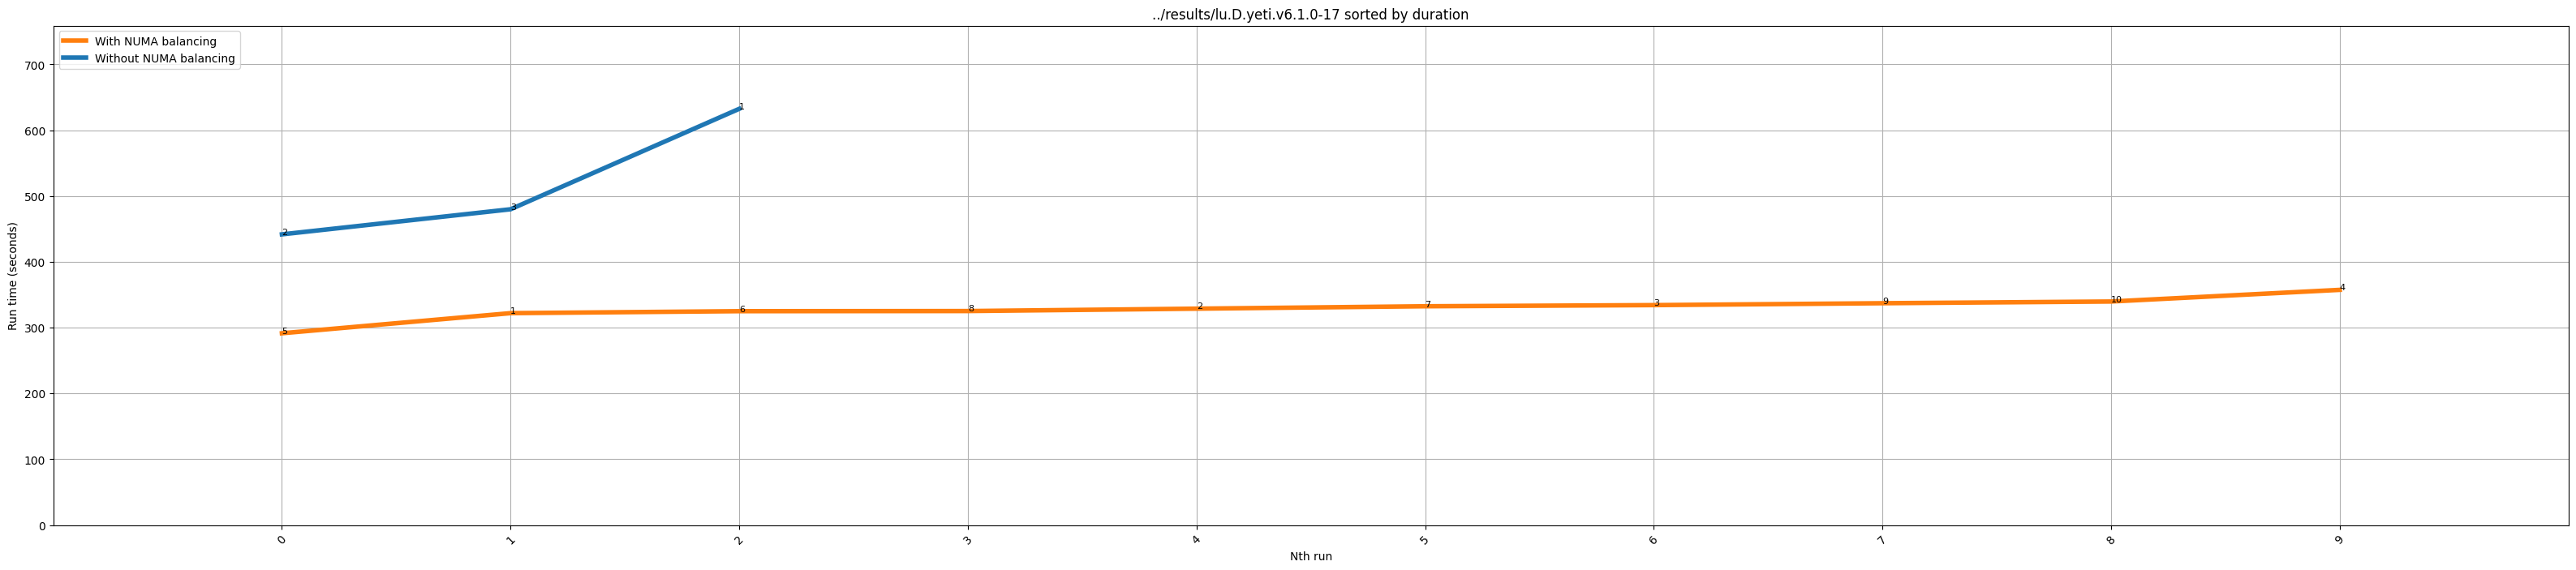

mg.d.dahu-28.v6.1.0-17


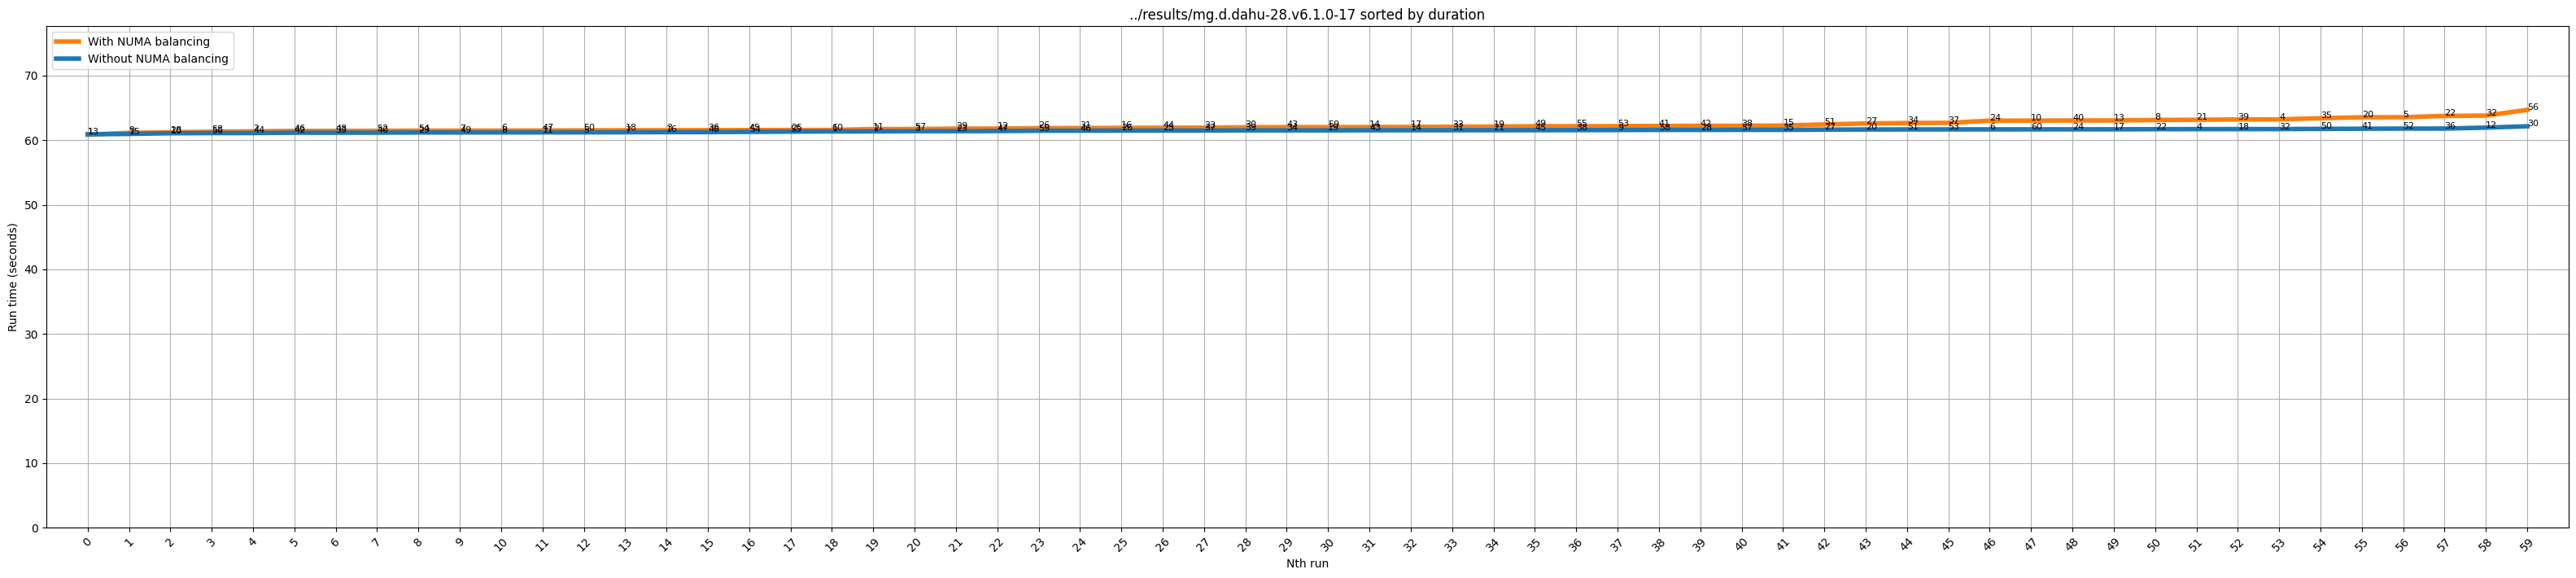

sp.C.dahu.v6.1.0-17


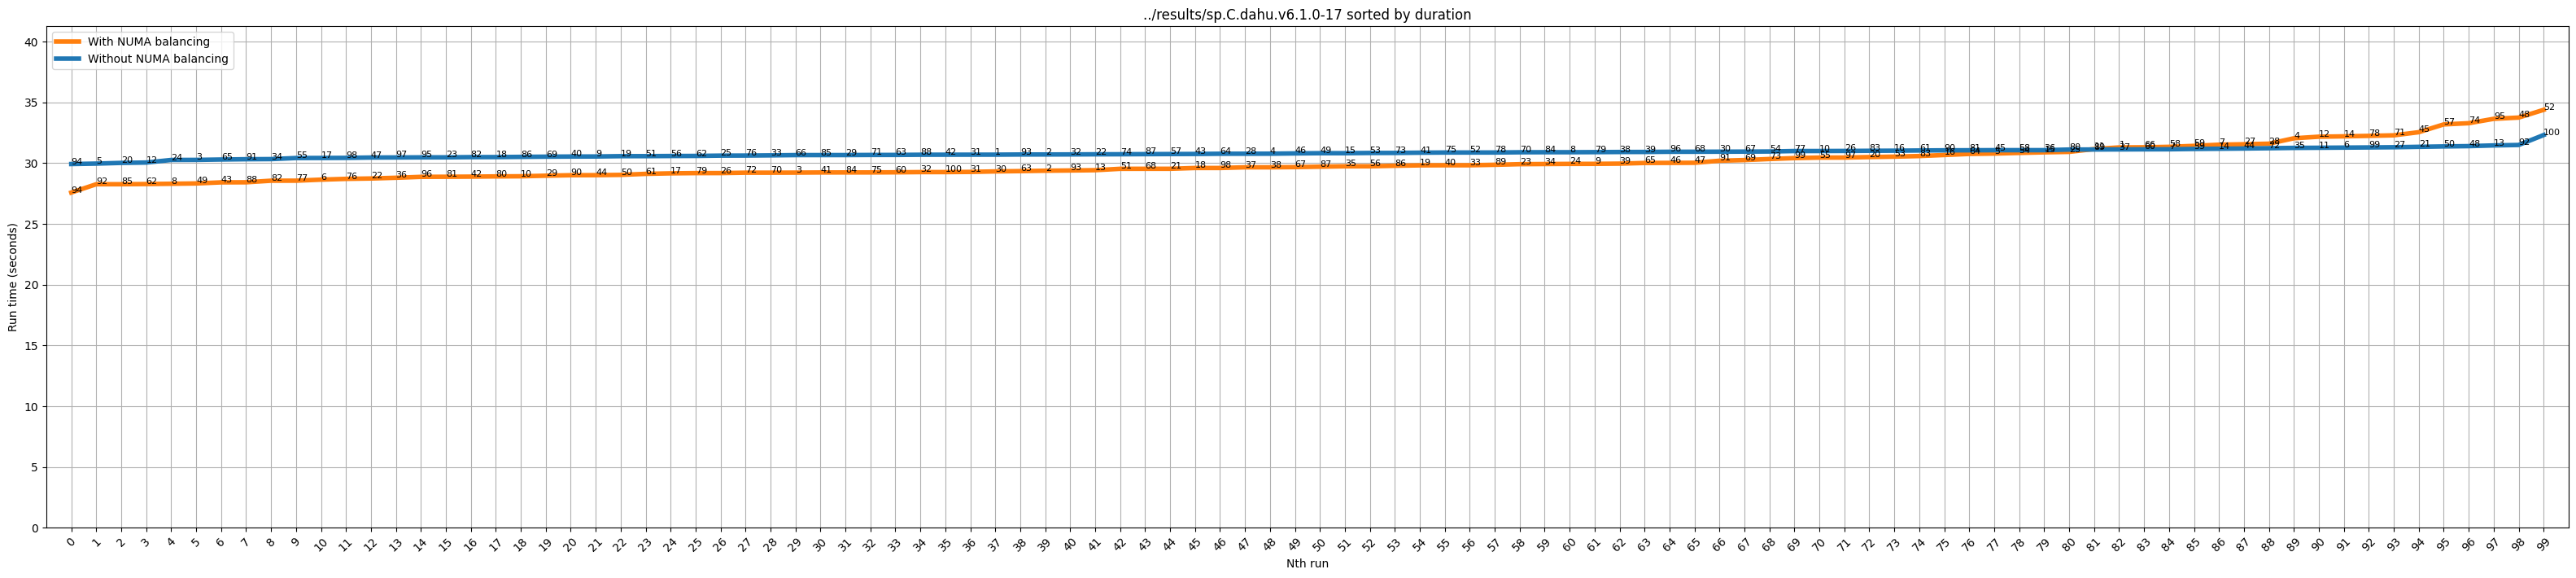

ua.C.dahu-30.v6.1.0-17


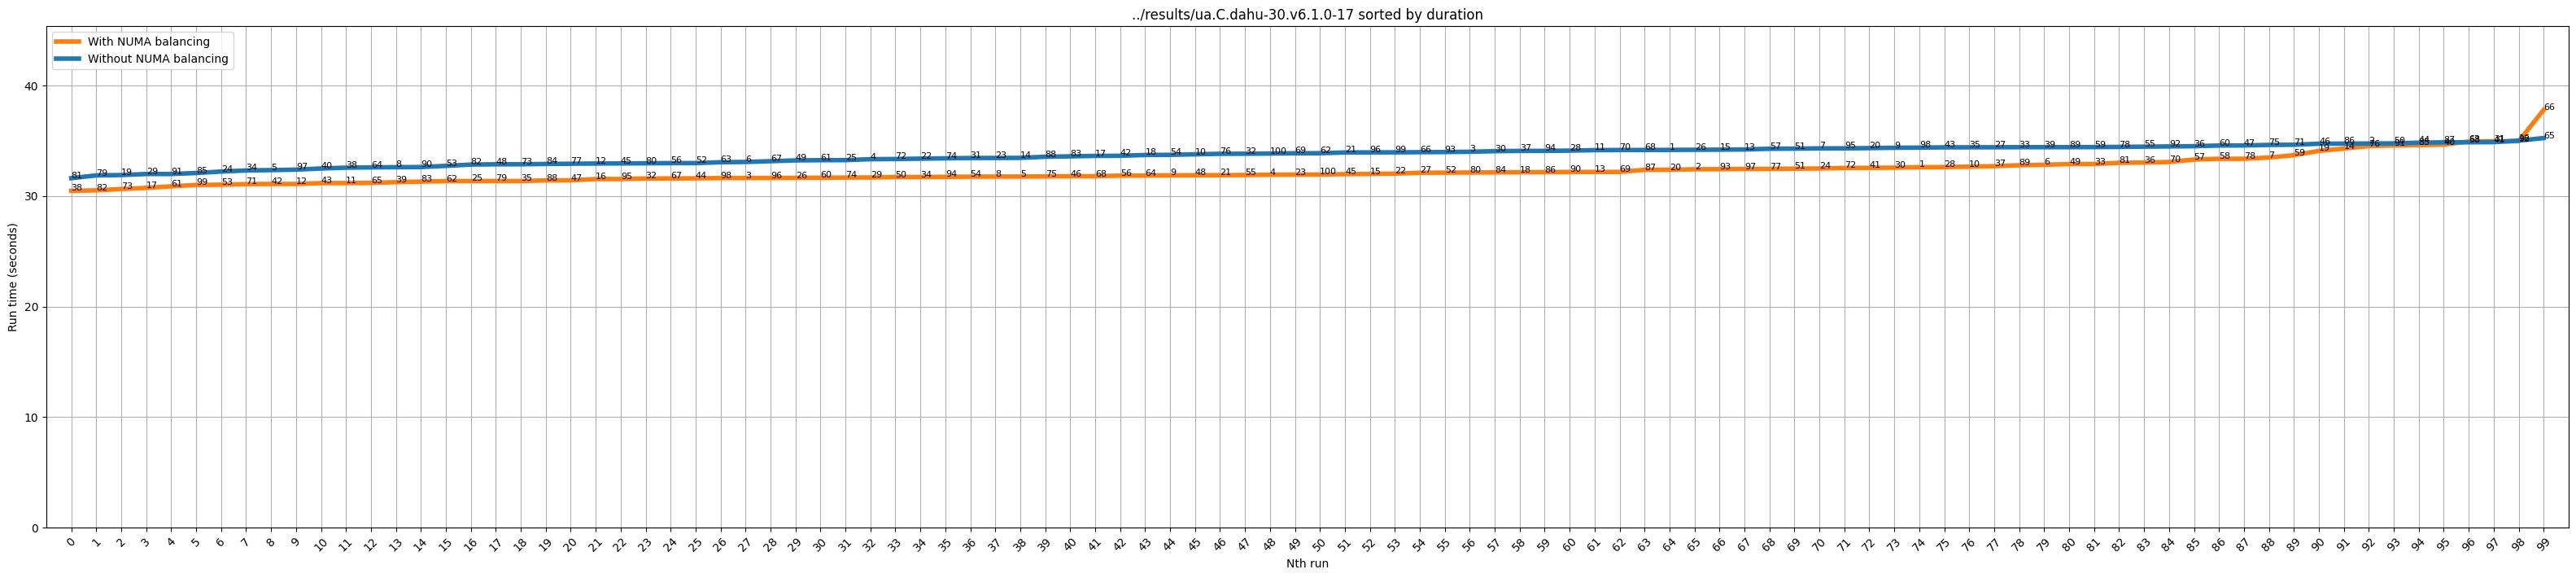

Done


In [105]:
for dir in trace_cmd_benchmark_dirs :
    if dir.endswith('rc3'):
        continue
    benchmark_dir = get_result_dir_path(dir)
    print(dir)
    plot_trace_cmd_benchmark_dir(benchmark_dir, show_run_index=True, sort_by='duration')
print("Done")

#### Thermal hypothesis

In [23]:
import os
import re
import pandas as pd

def parse_adapter_block(content: str, block_name: str) :
    temperatures = {'Tctl': [], 'Tccd1': [], 'Tccd3': [], 'Tccd5': [], 'Tccd7': []}
    temperature_pattern = re.compile(r'(Tctl|Tccd1|Tccd3|Tccd5|Tccd7):[ ]+([\+\-]?\d+\.\d+)')
    temperature_matches = temperature_pattern.findall(content)
    
    # for key, value in temperature_matches:
    #     temperatures[key].append(float(value))

    return {f"{block_name}:{first}": float(second) for first, second in temperature_matches}

def parse_thermal_file(file_path):
    with open(file_path, 'r') as file:
        text = file.read()

    initial_temperatures_match = re.search(r'Initial temperatures :\s+(.*?)\s+Final temperatures', text, re.DOTALL)
    if not initial_temperatures_match :
        return
    c3_match = re.search(r'k10temp-pci-00c3\n(.*?)\n\n', initial_temperatures_match.group(0), re.DOTALL)
    if c3_match :
        c3_temperatures = parse_adapter_block(c3_match.group(0), "c3")
    cb_match = re.search(r'k10temp-pci-00cb\n(.*?)\n\n', initial_temperatures_match.group(0), re.DOTALL)
    if cb_match :
        cb_temperatures = parse_adapter_block(cb_match.group(0), "cb")

    return c3_temperatures | cb_temperatures

def process_thermal_files(directory):
    # Initialize DataFrame
    df = pd.DataFrame()

    thermal_files = [file for file in os.listdir(directory) if file.endswith(".txt")]
    for i in range(1, len(thermal_files)) :
        filename = f"nbenabled_thermal_{i}_.txt"
        filepath = os.path.join(directory, filename)
        if not os.path.exists(filepath) :
            print(f"File {filename} not found")
            continue
        thermal_data = parse_thermal_file(filepath)
        df = pd.concat([df, pd.DataFrame([thermal_data])], ignore_index=True)

    return df

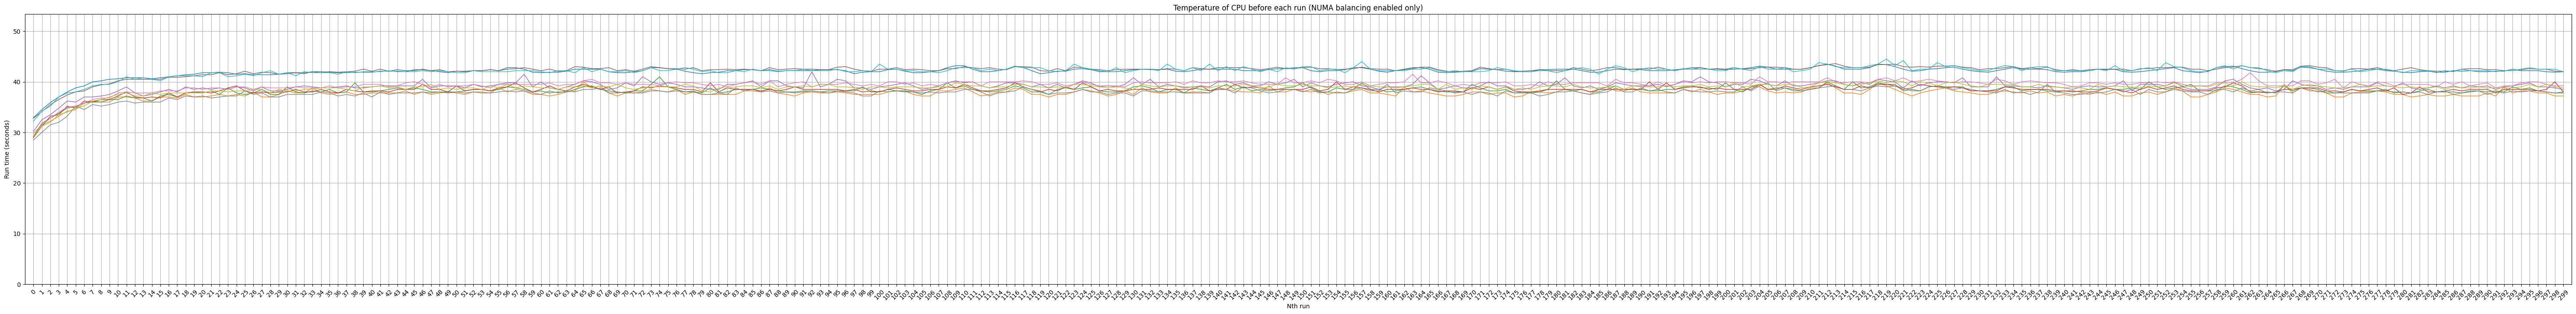

In [25]:
directory = get_result_dir_path("cg.C.servan-2.thermal2.v6.8-rc3/nb")
thermal_df = process_thermal_files(directory)
init_runtimes_plot()
for col in thermal_df.columns :
    plot_hyperfine_run(thermal_df[col], label = None, color = None, init_plot = False)
plt.title("Temperature of CPU before each run (NUMA balancing enabled only)")
plt.show()

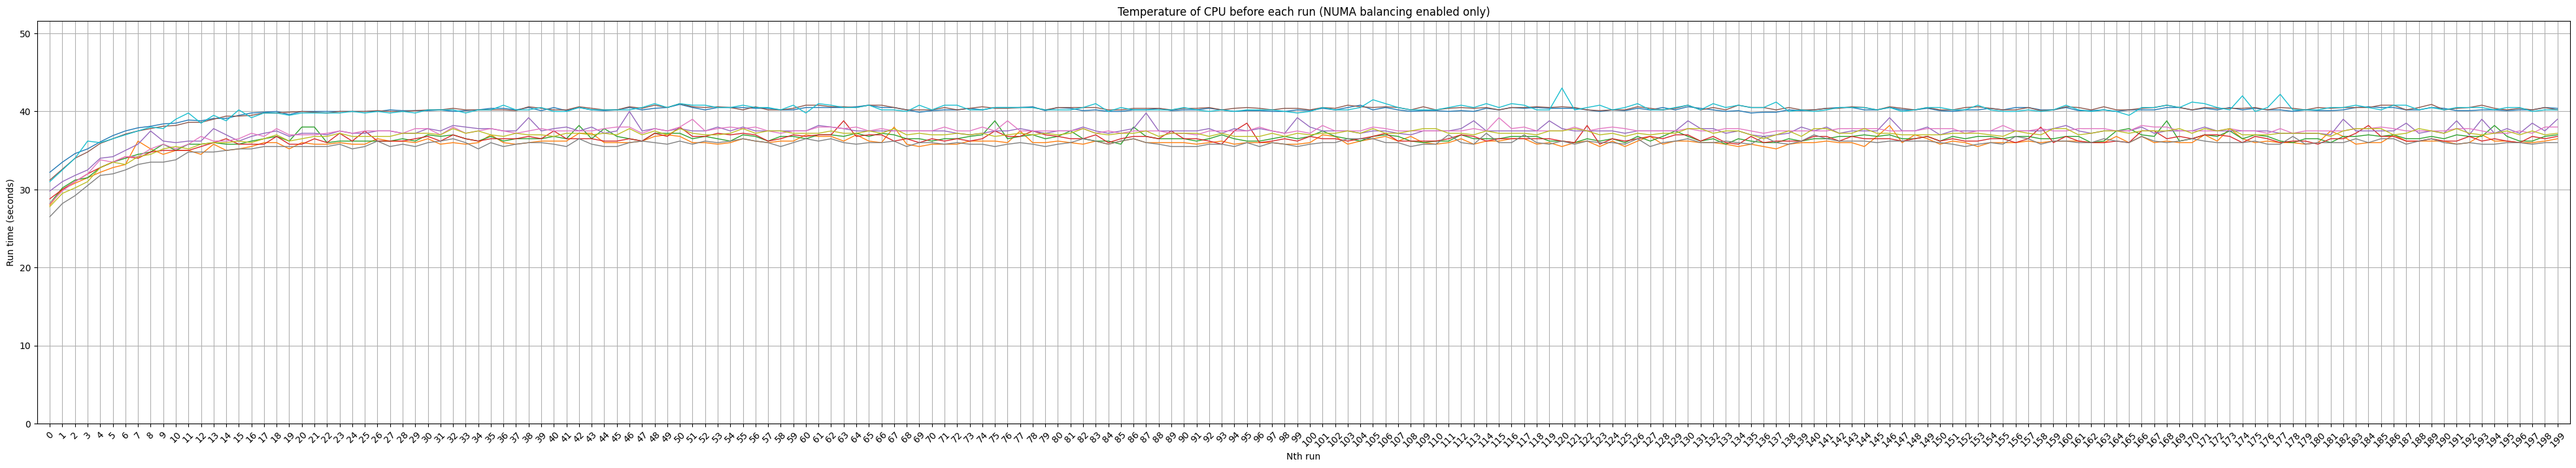

In [24]:
directory = get_result_dir_path("lu.B.27-02.thermal.servan-2.v6.8-rc3/nb")
thermal_df = process_thermal_files(directory)
init_runtimes_plot()
for col in thermal_df.columns :
    plot_hyperfine_run(thermal_df[col], label = None, color = None, init_plot = False)
plt.title("Temperature of CPU before each run (NUMA balancing enabled only)")
plt.show()